In [1]:
from functools import partial
from itertools import product
import numpy as np
from plotnine import ggplot, geom_point, qplot, coord_fixed, aes
import polars as pl
from torch.distributions.dirichlet import Dirichlet
import torch
from scipy.sparse import coo_array
from scipy import linalg
import scipy.sparse.linalg as sparselinalg
from tqdm.notebook import tqdm
import polars as pl
import zstandard as zstd

In [2]:
torch.cuda.is_available()

True

## Set Up

The basic idea is to sample synthetic n-gram distributions, fit a language model to learn the distribution, and then analyze how the model represents n-gram information.

If there are $|V| = v$ "tokens" in the vocabulary then our n-gram model will be a Markov chain with a $v^n \times v^n$ transition matrix.

In [3]:
from itertools import starmap
from functools import partial

def in_base_vocab(n_vocab, *indices):
    base_sixteen = reversed([n_vocab**i for i in range(len(indices))])
    return sum([b * idx for (b, idx) in zip(base_sixteen, indices)])


In [4]:
from tokengrams import MemmapIndex, InMemoryIndex

In [5]:
from datasets import load_dataset

tinystories = load_dataset("roneneldan/TinyStories")

Repo card metadata block was not found. Setting CardData to empty.


In [6]:
from transformers import AutoTokenizer
from transformers import GPTNeoXForCausalLM, GPTNeoXTokenizerFast


In [7]:
from transformer_lens import HookedTransformer, HookedTransformerConfig

In [8]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer/tinystories512")


In [9]:
from pathlib import Path

ts_bin_path = 'data/tinystories/train.bin'
index_path = "data/tinystories/ngrams/suffix_tree.idx"

index = MemmapIndex(ts_bin_path, index_path)

#index = MemmapIndex.build(
#    ts_bin_path,
#    ,
#    verbose=True
#)

In [11]:
epoch = 200

ckpt = torch.load(model_path / f'ckpt{epoch}.pt')

In [12]:
import einops

def nanogpt_to_hooked_transformer_config(model_args):
    cfg_dict = {
        "d_model": model_args['n_embed'],
        "n_layers": model_args["n_layer"],
        "d_mlp": model_args["n_embed"] * 4,
        "d_head": model_args["n_embed"] // model_args['n_head'],
        "n_heads": model_args["n_head"],
        "n_ctx": model_args["block_size"],
        "d_vocab": model_args["vocab_size"],
        "tokenizer_name": None,
        "act_fn": 'gelu',
        "attn_only": False,
        "positional_embedding_type": "standard",
        "normalization_type": "LN",
        "original_architecture": 'nanogpt'
    }
    return HookedTransformerConfig(**cfg_dict)

config = nanogpt_to_hooked_transformer_config(ckpt['model_args'])

In [13]:
def convert_nanogpt_weights(old_state_dict, cfg: HookedTransformerConfig):
    """For https://github.com/karpathy/nanoGPT
    There are two complications with converting nanogpt models:
    The first is that some state dicts have an unwanted prefix on keys that needs to be removed.
    The second is that the models can be saved with or without bias. By default, there
    is no bias. This function can handle both cases."""
    # Nanogpt models saved after torch.compile() have this unwanted prefix
    # This is a simple way to remove it
    unwanted_prefix = "_orig_mod."
    for k, v in list(old_state_dict.items()):
        if k.startswith(unwanted_prefix):
            old_state_dict[k[len(unwanted_prefix) :]] = old_state_dict.pop(k)

    new_state_dict = {}
    new_state_dict["pos_embed.W_pos"] = old_state_dict["transformer.wpe.weight"]
    new_state_dict["embed.W_E"] = old_state_dict["transformer.wte.weight"]

    new_state_dict["ln_final.w"] = old_state_dict["transformer.ln_f.weight"]
    new_state_dict["ln_final.b"] = torch.zeros_like(old_state_dict["transformer.ln_f.weight"])
    new_state_dict["unembed.W_U"] = old_state_dict["lm_head.weight"].T


    bias = False
    if "transformer.ln_f.bias" in old_state_dict:
        bias = True
        new_state_dict["ln_final.b"] = old_state_dict["transformer.ln_f.bias"]
    else:
         new_state_dict["unembed.b_U"] = torch.zeros(cfg.d_vocab, dtype=cfg.dtype)

    for layer in range(cfg.n_layers):
        layer_key = f"transformer.h.{layer}"

        new_state_dict[f"blocks.{layer}.ln1.w"] = old_state_dict[f"{layer_key}.ln_1.weight"]
        # A bias of zeros is required for folding layer norm
        new_state_dict[f"blocks.{layer}.ln1.b"] = torch.zeros_like(
            old_state_dict[f"{layer_key}.ln_1.weight"]
        )
        new_state_dict[f"blocks.{layer}.ln2.w"] = old_state_dict[f"{layer_key}.ln_2.weight"]
        new_state_dict[f"blocks.{layer}.ln2.b"] = torch.zeros_like(
            old_state_dict[f"{layer_key}.ln_2.weight"]
        )

        new_state_dict[f'blocks.{layer}.attn.mask'] = torch.tril(
            torch.ones((cfg.n_ctx, cfg.n_ctx)).bool()
        )
        new_state_dict[f'blocks.{layer}.attn.IGNORE'] = torch.tensor(-torch.inf)

        W = old_state_dict[f"{layer_key}.attn.c_attn.weight"]
        W_Q, W_K, W_V = torch.tensor_split(W, 3, dim=0)
        W_Q = einops.rearrange(W_Q, "(i h) m->i m h", i=cfg.n_heads)
        W_K = einops.rearrange(W_K, "(i h) m->i m h", i=cfg.n_heads)
        W_V = einops.rearrange(W_V, "(i h) m->i m h", i=cfg.n_heads)
        new_state_dict[f"blocks.{layer}.attn.W_Q"] = W_Q
        new_state_dict[f"blocks.{layer}.attn.W_K"] = W_K
        new_state_dict[f"blocks.{layer}.attn.W_V"] = W_V

        W_O = old_state_dict[f"{layer_key}.attn.c_proj.weight"]
        W_O = einops.rearrange(W_O, "m (i h)->i h m", i=cfg.n_heads)
        new_state_dict[f"blocks.{layer}.attn.W_O"] = W_O

        new_state_dict[f"blocks.{layer}.mlp.W_in"] = old_state_dict[
            f"{layer_key}.mlp.c_fc.weight"
        ].T
        new_state_dict[f"blocks.{layer}.mlp.W_out"] = old_state_dict[
            f"{layer_key}.mlp.c_proj.weight"
        ].T

        if bias:
            new_state_dict[f"blocks.{layer}.ln1.b"] = old_state_dict[f"{layer_key}.ln_1.bias"]
            new_state_dict[f"blocks.{layer}.ln2.b"] = old_state_dict[f"{layer_key}.ln_2.bias"]
            new_state_dict[f"blocks.{layer}.mlp.b_in"] = old_state_dict[
                f"{layer_key}.mlp.c_fc.bias"
            ]
            new_state_dict[f"blocks.{layer}.mlp.b_out"] = old_state_dict[
                f"{layer_key}.mlp.c_proj.bias"
            ]

            B = old_state_dict[f"{layer_key}.attn.c_attn.bias"]
            B_Q, B_K, B_V = torch.tensor_split(B, 3, dim=0)
            B_Q = einops.rearrange(B_Q, "(i h)->i h", i=cfg.n_heads)
            B_K = einops.rearrange(B_K, "(i h)->i h", i=cfg.n_heads)
            B_V = einops.rearrange(B_V, "(i h)->i h", i=cfg.n_heads)
            new_state_dict[f"blocks.{layer}.attn.b_Q"] = B_Q
            new_state_dict[f"blocks.{layer}.attn.b_K"] = B_K
            new_state_dict[f"blocks.{layer}.attn.b_V"] = B_V
            new_state_dict[f"blocks.{layer}.attn.b_O"] = old_state_dict[
                f"{layer_key}.attn.c_proj.bias"
            ]
        else:
            new_state_dict[f"blocks.{layer}.mlp.b_out"] = torch.zeros(cfg.d_model, dtype=cfg.dtype)
            new_state_dict[f"blocks.{layer}.mlp.b_in"] = torch.zeros(cfg.d_mlp, dtype=cfg.dtype)
            new_state_dict[f"blocks.{layer}.attn.b_Q"] = torch.zeros(
                (cfg.n_heads, cfg.d_head), dtype=cfg.dtype)
            new_state_dict[f"blocks.{layer}.attn.b_K"] = torch.zeros(
                cfg.n_heads, cfg.d_head, dtype=cfg.dtype)
            new_state_dict[f"blocks.{layer}.attn.b_V"] = torch.zeros(
                cfg.n_heads, cfg.d_head, dtype=cfg.dtype)
            new_state_dict[f"blocks.{layer}.attn.b_O"] = torch.zeros(cfg.d_model, dtype=cfg.dtype)
            
    return new_state_dict

In [14]:
from ngram_markov.model import GPT, GPTConfig
from torch.nn.functional import softmax


def check_similarity_with_hf_model(tl_model, gpt_model, tokens, atol):
    tl_logits = tl_model(tokens)
    gpt_logits, _ = gpt_model(tokens)
    assert torch.allclose(softmax(tl_logits, dim=-1), softmax(gpt_logits, dim=-1), atol=atol)

tl_weights = convert_nanogpt_weights(ckpt['model'], config)
tl_model = HookedTransformer(config)
tl_model.load_state_dict(tl_weights)

#gpt_config = GPTConfig(**ckpt['model_args'])

#gpt_model = GPT(gpt_config)
#gpt_model.load_state_dict(ckpt['model'])
#gpt_model.to('cuda')

<All keys matched successfully>

In [15]:
from ngram_markov.utils import create_ngrams

In [138]:
ngram_seed = tokenizer.encode(" my name is")

In [141]:
len(index.positions(ngram_seed))

2078

In [192]:
n = 4

random_walks = index.batch_sample([0], n=n, k=200, num_samples=200)

In [193]:
import collections
from itertools import islice

def sliding_window(iterable, n):
    "Collect data into overlapping fixed-length chunks or blocks."
    # sliding_window('ABCDEFG', 4) → ABCD BCDE CDEF DEFG
    iterator = iter(iterable)
    window = collections.deque(islice(iterator, n - 1), maxlen=n)
    for x in iterator:
        window.append(x)
        yield tuple(window)


In [194]:
from collections import defaultdict

def seq_to_debruijn(rw, n):
    return [ngram for ngram in sliding_window(rw, n)]

ngram_walks = [seq_to_debruijn(rw, n) for rw in random_walks]


In [195]:
unique_ngrams = set()
for walk in ngram_walks:
    unique_ngrams.update(walk)

In [228]:
import rustworkx as rx
import numpy as np
from typing import List, Tuple
from collections import defaultdict


class NgramNode:

    def __init__(self, ngram: Tuple[int]):
        self.ngram = ngram

    def __repr__(self):
        return self.ngram.__repr__()

def create_weighted_debruijn_subgraph(ngram_walks: List[List[Tuple[int]]], index) -> rx.PyDiGraph:
    # Step 1: Create a set of unique 3-grams (nodes)
    unique_ngrams = set()
    for walk in ngram_walks:
        unique_ngrams.update(walk)
    unique_ngrams = list(unique_ngrams)
    
    # Step 2: Create a dictionary to map n-grams to node indices
    ngram_to_index = {ngram: i for i, ngram in enumerate(unique_ngrams)}
    
    # Step 3: Create dictionaries for prefix and suffix matching
    prefix_dict = defaultdict(set)
    suffix_dict = defaultdict(set)
    for ngram in unique_ngrams:
        prefix = ngram[:-1]
        suffix = ngram[1:]
        prefix_dict[prefix].add(ngram)
        suffix_dict[suffix].add(ngram)
    
    # Step 4: Calculate n-gram transition probabilities
    ngram_dist = np.array(index.batch_count_next(list(unique_ngrams), 511), dtype=np.float32)
    ngram_dist /= ngram_dist.sum(axis=1)[:, None]
    
    # Step 5: Create all possible edges with weights
    weighted_edges = []
    for ngram in unique_ngrams:
        suffix = ngram[1:]
        source = ngram_to_index[ngram]
        for next_ngram in prefix_dict[suffix]:
            target = ngram_to_index[next_ngram]
            weight = ngram_dist[source, next_ngram[-1]]
            if weight > 0:
                weighted_edges.append((source, target, weight))
    
    # Step 6: Build the rustworkx graph
    graph = rx.PyDiGraph(multigraph=False)
    graph.add_nodes_from([NgramNode(gram) for gram in unique_ngrams])
    graph.add_edges_from(weighted_edges)
    
    return graph, ngram_to_index

# Usage
graph, ngram_to_index = create_weighted_debruijn_subgraph(ngram_walks, index)

# Print some basic information about the subgraph
print(f"Number of nodes: {graph.num_nodes()}")
print(f"Number of edges: {graph.num_edges()}")

# Function to get the original 3-gram for a given node index
index_to_ngram = {i: ngram for ngram, i in ngram_to_index.items()}

# Print some example edges with weights to verify
print("\nSample edges with weights:")
for edge in list(graph.weighted_edge_list())[:5]:  # Print first 5 edges
    source_ngram = index_to_ngram[edge[0]]
    target_ngram = index_to_ngram[edge[1]]
    weight = edge[2]
    print(f"{source_ngram} -> {target_ngram} (weight: {weight:.4f})")

Number of nodes: 29088
Number of edges: 56770

Sample edges with weights:
(282, 259, 258, 268) -> (259, 258, 268, 89) (weight: 0.9973)
(338, 273, 389, 282) -> (273, 389, 282, 259) (weight: 0.4580)
(14, 313, 460, 438) -> (313, 460, 438, 69) (weight: 0.9978)
(258, 422, 449, 263) -> (422, 449, 263, 334) (weight: 0.0215)
(318, 263, 273, 73) -> (263, 273, 73, 271) (weight: 0.9169)


In [229]:
scc = rx.strongly_connected_components(graph)
scc_idx = -1
scc_len = -1
for i, cc in enumerate(scc):
    if len(cc) > 1:
        if len(cc) > scc_len:
            scc_idx = i
            scc_len = len(cc)
        print(f'{i} {len(cc)}')
        

3521 23028


In [230]:
scc_idx

3521

In [231]:

connected_subgraph = graph.subgraph(scc[scc_idx], preserve_attrs=True)
adj_mat = rx.adjacency_matrix(connected_subgraph, weight_fn= lambda x: float(x))

In [236]:
connected_subgraph[4]

(478, 259, 86, 65)

In [237]:
norm_adj_mat = adj_mat / adj_mat.sum(axis=1)[:, None]

In [238]:
norm_adj_mat.sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [239]:
from scipy.sparse import csr_array

adj = csr_array(norm_adj_mat)

In [243]:

adj = csr_array(norm_adj_mat.T)

eigenvalues, eigenvectors = sparselinalg.eigs(adj, k = 15, which='LM')

eigen_real = eigenvectors.squeeze().real
perron = None
for i in range(eigen_real.shape[1]):
    if np.all(eigen_real[:, i] > 0):
        perron = eigen_real[:, i]
if perron is None:
    raise ValueError('For some reason the Perron vector has negative values')

In [244]:
perron

array([4.44503425e-03, 9.23041497e-05, 2.26353972e-03, ...,
       2.95967550e-04, 1.36013082e-03, 2.61704261e-03])

In [245]:
def to_cola_sparse(matrix, dtype=torch.float32):
    shape = matrix.shape
    if dtype == torch.float64:
        indtype = torch.int64
    else:
        indtype = torch.int32
    
    return cola.ops.Sparse(
        data=torch.from_numpy(np.array(matrix.data)).to(dtype),
        indices=torch.from_numpy(np.array(matrix.indices)).to(indtype),
        indptr=torch.from_numpy(np.array(matrix.indptr)).to(indtype),
        shape=shape
    )


In [247]:
import scipy
from scipy.sparse import csr_array
import cola

def calc_perron_vector(adjacency_matrix, k=2):
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(
        csr_array(adj),
        k=2, 
        which='LM'
    )
    eigen_real = eigenvectors.squeeze().real
    perron = None
    for i in range(eigen_real.shape[1]):
        if np.all(eigen_real[:, i] > 0):
            perron = eigen_real[:, i]
    if perron is None:
        raise ValueError('For some reason the Perron vector has negative values. Try re-calculating with larger k')
    return eigenvectors.squeeze().real
    

def symmetric_directed_laplacian(adjacency_matrix, perron_vector, dtype=torch.float32):
    n = adjacency_matrix.shape[0]
    perron = cola.ops.Diagonal(torch.from_numpy(perron_vector).to(dtype))
    adj = cola.ops.Dense(torch.from_numpy(adjacency_matrix).to(dtype))
    #adj = to_cola_sparse(adjacency_matrix, dtype)
    Ident = cola.ops.I_like(perron)

    laplacian = (cola.sqrt(perron) @ adj @ cola.inv(cola.sqrt(perron)))
    laplacian +=  (cola.inv(cola.sqrt(perron)) @ adj.T @ cola.sqrt(perron))
    laplacian /= 2
                   
    return cola.SelfAdjoint(Ident - laplacian)

In [248]:
laplacian = symmetric_directed_laplacian(norm_adj_mat, perron)
laplacian.to('cuda')

<23028x23028 Sum[cola.ops.operators.Identity, cola.ops.operators.Product[cola.ops.operators.ScalarMul, cola.ops.operators.Product[cola.ops.operators.ScalarMul, cola.ops.operators.Sum[cola.ops.operators.Product[cola.ops.operators.Diagonal, cola.ops.operators.Dense, cola.ops.operators.Diagonal], cola.ops.operators.Product[cola.ops.operators.Diagonal, cola.ops.operators.Dense, cola.ops.operators.Diagonal]]]]] with dtype=torch.float32>

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], dtype=torch.float64)

In [249]:
top_eigvals, top_eigvecs = cola.eig(laplacian, k=1000, which='LM')

In [250]:
top_eigvals

tensor([2.2765e-06, 1.4329e-05, 1.4579e-03, 1.2376e-02, 1.2633e-02, 1.4883e-02,
        1.5926e-02, 1.6225e-02, 1.7870e-02, 1.8293e-02, 1.8409e-02, 1.9025e-02,
        1.9122e-02, 1.9953e-02, 2.0387e-02, 2.0768e-02, 2.1119e-02, 2.1404e-02,
        2.2146e-02, 2.2228e-02, 2.2290e-02, 2.2517e-02, 2.2653e-02, 2.2769e-02,
        2.2940e-02, 2.3115e-02, 2.3145e-02, 2.3407e-02, 2.3796e-02, 2.4010e-02,
        2.4276e-02, 2.4678e-02, 2.4796e-02, 2.5214e-02, 2.5376e-02, 2.5605e-02,
        2.6058e-02, 2.6329e-02, 2.6659e-02, 2.6939e-02, 2.7326e-02, 2.7720e-02,
        2.8010e-02, 2.8489e-02, 2.9030e-02, 2.9422e-02, 2.9741e-02, 3.0158e-02,
        3.0633e-02, 3.1100e-02, 3.1628e-02, 3.2008e-02, 3.2540e-02, 3.3115e-02,
        3.3502e-02, 3.4054e-02, 3.4727e-02, 3.5260e-02, 3.5690e-02, 3.6235e-02,
        3.6670e-02, 3.7311e-02, 3.8141e-02, 3.8549e-02, 3.9220e-02, 3.9831e-02,
        4.0331e-02, 4.1065e-02, 4.1643e-02, 4.2618e-02, 4.3066e-02, 4.3594e-02,
        4.4538e-02, 4.5154e-02, 4.5796e-

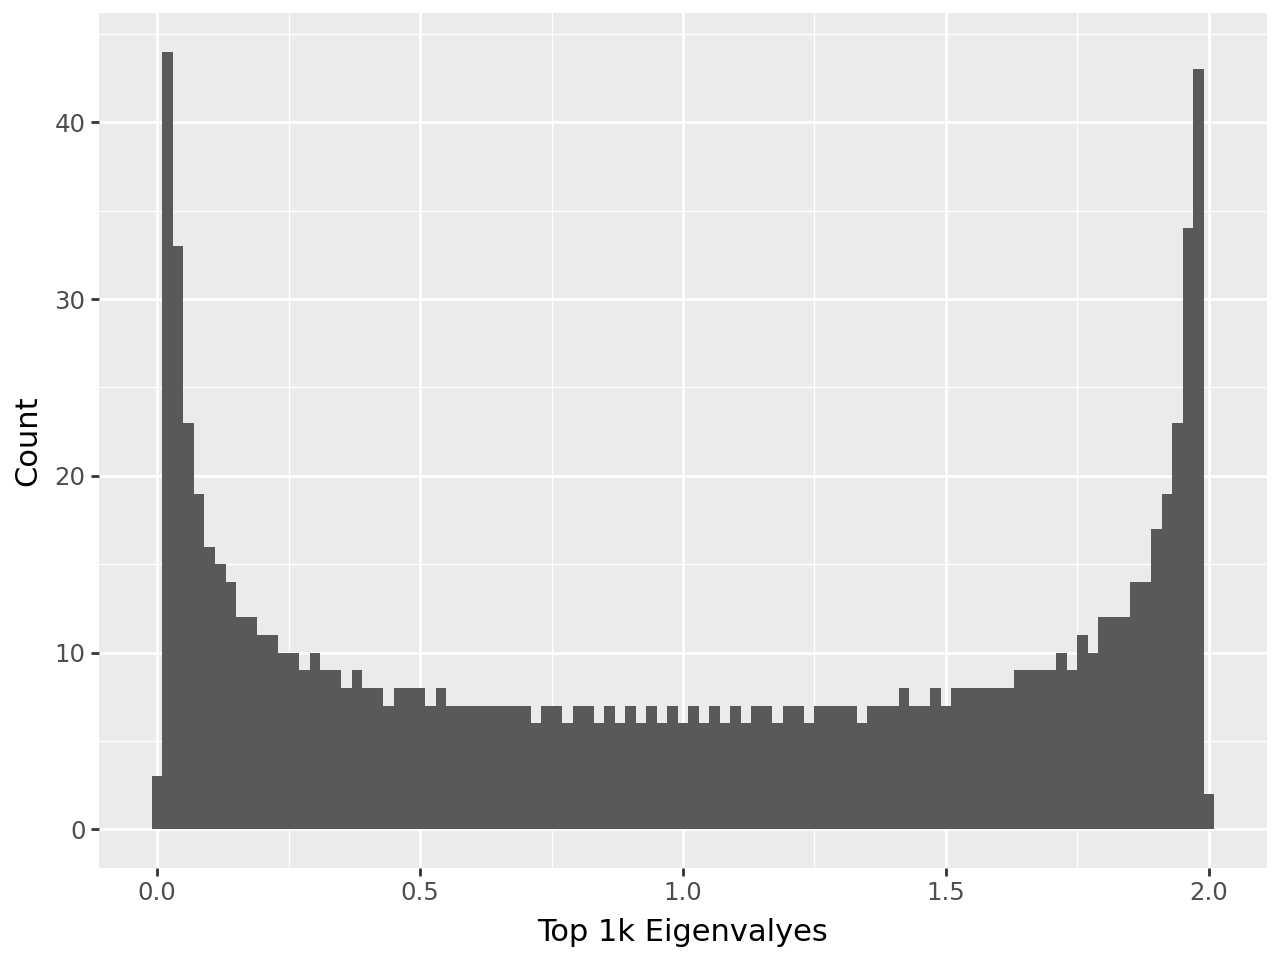

In [251]:
from plotnine import qplot, ggplot, geom_histogram, aes, labs
import polars as pl

data = pl.DataFrame({'eigvals': top_eigvals.numpy()})

ggplot(data, aes(x='eigvals')) + geom_histogram(binwidth=0.02) + labs(x='Top 1k Eigenvalues', y='Count')

In [252]:
eigvecs = top_eigvecs.to_dense()

In [253]:
eigvecs.shape

torch.Size([23028, 1000])

In [258]:
eigvecs.pow(2).sum(dim=0)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

In [37]:
eigenvalues, eigenvectors = sparselinalg.eigs(csr_array(laplacian), k = 1000, which='LM')

In [42]:
np.abs(eigenvectors.imag).max()

0.0

In [78]:
np.power(perron, -0.5)

array([82.01772326, 32.46641505, 12.06707508, ..., 11.96920964,
       54.20458141, 14.42476404])

In [82]:
import networkx as nx


def convert_rustworkx_to_networkx(graph):
    """Convert a rustworkx PyGraph or PyDiGraph to a networkx graph."""
    edge_list = [(
        graph[x[0]], graph[x[1]],
        {'weight': x[2]}) for x in graph.weighted_edge_list()]

    if isinstance(graph, rx.PyGraph):
        if graph.multigraph:
            return nx.MultiGraph(edge_list)
        else:
            return nx.Graph(edge_list)
    else:
        if graph.multigraph:
            return nx.MultiDiGraph(edge_list)
        else:
            return nx.DiGraph(edge_list)



In [83]:
adj_mat = nx.adjacency_matrix(nx_graph)

In [94]:
adj_mat

<5618x5618 sparse array of type '<class 'numpy.float32'>'
	with 23502 stored elements in Compressed Sparse Row format>

In [ ]:
import rustworkx as rx

node_index = {}
rw_graph = rx.PyDiGraph()


for ngram in ngram_tuples:
    if ngram in node_index:
        continue
    else:   
        node_index[ngram] = rw_graph.add_node(ngram)
    



ngram_tuples

In [28]:
rw_ngrams = torch.vmap(create_ngrams, in_dims=(0, None))(torch.tensor(random_walks), 3)
rw_ngrams.shape

torch.Size([5000, 201, 3])

In [21]:
from ngram_markov.ngrams import create_ngrams, calculate_ngram_kl_divergence


data_dir = Path('data/tinystories')
n = 2
batch_size = 8
block_size = 1024
device_type = 'cuda'
device = 'cuda'

def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap(data_dir / 'train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap(data_dir / 'validation.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y


batch, _ = get_batch('train')
#ngrams = create_ngrams(batch.cpu(), n-1)

In [22]:

@torch.no_grad()
def get_layerwise_logits(model, data):
    layers = {}
    logits, cache = model.run_with_cache(batch)
    layers[8] = logits.detach().cpu()
    for i in range(8):
        layers[i] = model.unembed(model.ln_final(cache['resid_pre', i])).cpu()
    return layers
        

In [23]:
def check_ngram_counts(index, tokens, ngrams, n):
    # Get the model's logits
    # Get the n-grams from the tokens
    #if n < 5:
    #    ngrams = ngrams.tocsr()
    #else:
    #    ngrams = ngrams.todok()
    token_ngrams = create_ngrams(tokens, n-1)

    # Convert n-grams to indices for accessing the sparse matrix
    vocab_size = ngrams.shape[1]
    exponents = vocab_size **  torch.flip(torch.arange(n - 1, device=tokens.device).view(1, 1, -1), [-1])
    indices = torch.sum(token_ngrams * exponents, dim=-1).detach().cpu()

    # Get the n-gram distributions from the sparse matrix
    file_ngram_counts = torch.tensor(ngrams[indices.view(-1).numpy()].toarray(), device=tokens.device)
    #file_ngram_distributions = ngram_counts / ngram_counts.sum(axis=1)[:, None]
    #file_ngram_distributions = ngram_distributions.view(tokens.shape[0], tokens.shape[1] - n + 2, vocab_size)

    #log_ngram_probs = torch.log(ngram_distributions + 1e-10)  # Add a small epsilon to avoid log(0)
    #log_model_probs = torch.log_softmax(logits[:, n-2:].contiguous(), dim=-1)
    index_ngram_counts = torch.tensor(index.batch_count_next(token_ngrams.reshape(-1, n-1).numpy(), 511), dtype=torch.float64)
        
    # Calculate the KL divergence between the n-gram distributions and the model's logits
    #kl_div = kl_divergence(log_ngram_probs, log_model_probs)

    assert torch.allclose(index_ngram_counts, file_ngram_counts)

In [1]:
import scipy.sparse as sp
import torch
from pathlib import Path

ngram_index_dir = Path('data/tinystories/ngrams')
ngram_files = {
    1: ngram_index_dir / '1grams.npy',
    2: ngram_index_dir / '2grams.npz',
    3: ngram_index_dir / '3grams.npz',
    4: ngram_index_dir / '4grams.npz',
    5: ngram_index_dir / '5grams.npz',
    6: ngram_index_dir / '6grams.npz',
}


n = 4
ngram_distribution = sp.load_npz(ngram_files[n]).tocoo()
ngram_distribution /= ngram_distribution.sum(axis=1)[:, None]

#for _ in range(100):
#    batch, _ = get_batch('train')
#    check_ngram_counts(index, batch.detach().cpu(), ngram_distribution, n)

/home/dashiell/workspace/ngram-markov/.venv/lib/python3.12/site-packages/scipy/sparse/_base.py:730: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)


In [2]:
ngram_distribution.sum(axis=1)

array([1., 0., 0., ..., 0., 0., 0.])

In [3]:
# Extract the row indices, column indices, and values
row_indices = torch.from_numpy(ngram_distribution.row).long()
col_indices = torch.from_numpy(ngram_distribution.col).long()
values = torch.from_numpy(ngram_distribution.data).to(torch.float32)

# Create a PyTorch sparse COO tensor
sparse_tensor = torch.sparse_coo_tensor(
    indices=torch.stack([row_indices, col_indices]),
    values=values,
    size=ngram_distribution.shape
)

In [4]:
ngrams = sparse_tensor.to('cuda')


In [5]:
U, S, V = torch.svd_lowrank(ngrams, q=5, niter=100)

In [6]:
S

tensor([164.6448, 154.2340, 151.0323, 149.0692, 136.0620], device='cuda:0')

In [24]:
from ngram_markov.ngrams import kl_divergence


def calculate_ngram_kl_divergence(model, tokens, index, n):
    # Get the model's logits
    with torch.no_grad():
        logits, _ = model(tokens)

    if n == 1:
        # Get the unigram distributions from the 1-D vector
        unigram_distribution = torch.tensor(ngrams, device=tokens.device)[None, None, :]
        unigram_distribution /= unigram_distribution.sum()
        log_ngram_probs = torch.log(unigram_distribution + 1e-10)  # Add a small epsilon to avoid log(0)
        log_model_probs = torch.log_softmax(logits, dim=-1)
    else:
        # Get the n-grams from the tokens
        #if n < 5:
        #    ngrams = ngrams.tocsr()
        #else:
        #    ngrams = ngrams.todok()
        
        token_ngrams = create_ngrams(tokens, n-1)

        # Convert n-grams to indices for accessing the sparse matrix
        vocab_size = 512
        #exponents = vocab_size **  torch.flip(torch.arange(n - 1, device=tokens.device).view(1, 1, -1), [-1])
        #indices = torch.sum(token_ngrams * exponents, dim=-1).detach().cpu()

        # Get the n-gram distributions from the sparse matrix
        ngram_counts = torch.tensor(index.batch_count_next(token_ngrams.reshape(-1, n-1).cpu().numpy(), 511), dtype=torch.float32)
        #ngram_counts = torch.tensor(ngrams[indices.view(-1).numpy()].toarray(), device=tokens.device)
        ngram_distributions = ngram_counts / ngram_counts.sum(axis=1)[:, None]
        ngram_distributions = ngram_distributions.view(tokens.shape[0], tokens.shape[1] - n + 2, vocab_size)
        #ngram_dist = (counts / counts.sum(dim=1, keepdims=True)) 
        #log_ngrams = torch.log(ngram_dist + 1.0e-10)
        
        log_ngram_probs = torch.log(ngram_distributions + 1e-10)  # Add a small epsilon to avoid log(0)
        log_model_probs = torch.log_softmax(logits[:, n-2:].contiguous(), dim=-1)
        print(logits.shape, log_model_probs.shape, logits[:, n-2:].shape)
        #logprobs = torch.log_softmax(layer_logits[j][:, (n-2):, :].reshape(-1, 512), dim=-1)
        
    # Calculate the KL divergence between the n-gram distributions and the model's logits
    kl_div = kl_divergence(log_ngram_probs, log_model_probs.detach().cpu())

    return kl_div

In [31]:
@torch.no_grad()
def get_layerwise_logits(model, data, num_layers):
    layers = {}
    logits, cache = model.run_with_cache(data)
    layers[num_layers] = logits
    for i in range(num_layers):
        layers[i] = model.unembed(model.ln_final(cache['resid_pre', i]))
    return layers


def estimate_unigram_kl(model, unigram_counts, num_batches, num_layers, vocab_size):
    layer_kl = {i: [] for i in range(num_layers + 1)}
    for i in range(num_batches):
        batch, _ = get_batch('train')
        #ngrams = create_ngrams(batch.cpu(), n-1)
        #counts = torch.tensor(index.batch_count_next(ngrams.reshape(-1, n-1).numpy(), 511), dtype=torch.float32)
        ngram_dist = torch.asarray((unigram_counts / unigram_counts.sum()))
        log_ngrams = torch.log(ngram_dist + 1.0e-10).to('cuda')
        for layer, logits in get_layerwise_logits(model, batch, num_layers).items():
            logprobs = torch.log_softmax(logits[:, (n-2):, :], dim=-1)
            layer_kl[layer].append(kl_divergence(log_ngrams, logprobs))
    return {layer : torch.stack(kls, dim=0).squeeze().detach().cpu() for layer, kls in layer_kl.items()}

@torch.no_grad()
def estimate_layer_kl(model, n, num_batches, num_layers, vocab_size):
    layer_kl = {i: [] for i in range(num_layers + 1)}
    for i in range(num_batches):
        batch, _ = get_batch('train')
        ngrams = create_ngrams(batch.cpu(), n-1)
        counts = torch.tensor(index.batch_count_next(ngrams.reshape(-1, n-1).numpy(), 511), dtype=torch.float32)
        ngram_dist = (counts / counts.sum(dim=1, keepdims=True)).reshape(batch.shape[0], batch.shape[1] - n + 2, vocab_size)
        log_ngrams = torch.log(ngram_dist + 1.0e-10).to('cuda')
        for layer, logits in get_layerwise_logits(model, batch, num_layers).items():
            logprobs = torch.log_softmax(logits[:, (n-2):, :], dim=-1)
            layer_kl[layer].append(kl_divergence(log_ngrams, logprobs))
    return {layer : torch.stack(kls, dim=0).squeeze().detach().cpu() for layer, kls in layer_kl.items()}
        

In [32]:
def get_kl_for_model(ckpt_path, iteration, ngram_vals, num_batches):
    unigram_dist = np.load('data/tinystories/ngrams/1grams.npy')
    ckpt = torch.load(ckpt_path / f'ckpt{iteration}.pt')
    num_layers = ckpt['model_args']['n_layer']
    vocab_size = ckpt['model_args']['vocab_size']
    config = nanogpt_to_hooked_transformer_config(ckpt['model_args'])
    tl_weights = convert_nanogpt_weights(ckpt['model'], config)
    model = HookedTransformer(config)
    model.load_state_dict(tl_weights)
    model.eval()
    ngram_dfs = {}
    for n in ngram_vals:
        if n == 1:
            ckpt_kl = estimate_unigram_kl(model, unigram_dist, num_batches, num_layers, vocab_size)
        else:
            ckpt_kl = estimate_layer_kl(model, n, num_batches, num_layers, vocab_size)
        data = {str(layer) : kl.ravel().numpy() for layer, kl in ckpt_kl.items()} 
        #for layer, v in data.items():
        #    print(f'{layer}: {v.shape}')
        ngram_dfs[n] = pl.DataFrame(data).melt(variable_name='layers').with_columns(steps=pl.lit(iteration))
    return ngram_dfs
    
    

In [37]:
from ngram_markov.ngrams import kl_divergence
from tqdm.notebook import tqdm, trange
import re
output_path = Path('/media/External01/ngram-checkpoints/4layer_tinystories')
pattern = re.compile(r'[0-9]+')

checkpoint_steps = sorted([int(pattern.search(str(p.name)).group(0)) for p in output_path.iterdir()])
checkpoint_steps = [s for s in checkpoint_steps if s < 10_000 or s % 5_000 != 0]
print(checkpoint_steps)

base_path = Path(f'two_layer_data/')
base_path.mkdir(exist_ok=True, parents=True)
for n in range(1, 21):
    print(f'{n}-grams')
    print('#' * 50)
    data = []
    df_path = base_path / f'{n}gram_kl_layers.parquet'
    if df_path.exists():
        continue
    for step in tqdm(checkpoint_steps):
        data.append(get_kl_for_model(output_path, step, [n], 32)[n])
    df = pl.concat(data)
    df.write_parquet(df_path)
    
    

[2, 4, 8, 16, 32, 64, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 11000, 12000, 13000, 14000, 16000, 17000, 18000, 19000, 21000, 22000, 23000, 24000, 26000, 27000, 28000, 29000, 31000, 32000, 33000, 34000, 36000, 37000, 38000, 39000, 41000, 42000, 43000, 44000, 46000, 47000, 48000, 49000, 51000, 52000, 53000]
1-grams
##################################################
2-grams
##################################################


  0%|          | 0/68 [00:00<?, ?it/s]

3-grams
##################################################


  0%|          | 0/68 [00:00<?, ?it/s]

4-grams
##################################################


  0%|          | 0/68 [00:00<?, ?it/s]

5-grams
##################################################


  0%|          | 0/68 [00:00<?, ?it/s]

6-grams
##################################################


  0%|          | 0/68 [00:00<?, ?it/s]

7-grams
##################################################


  0%|          | 0/68 [00:00<?, ?it/s]

8-grams
##################################################


  0%|          | 0/68 [00:00<?, ?it/s]

9-grams
##################################################


  0%|          | 0/68 [00:00<?, ?it/s]

10-grams
##################################################


  0%|          | 0/68 [00:00<?, ?it/s]

11-grams
##################################################


  0%|          | 0/68 [00:00<?, ?it/s]

12-grams
##################################################


  0%|          | 0/68 [00:00<?, ?it/s]

13-grams
##################################################


  0%|          | 0/68 [00:00<?, ?it/s]

14-grams
##################################################


  0%|          | 0/68 [00:00<?, ?it/s]

15-grams
##################################################


  0%|          | 0/68 [00:00<?, ?it/s]

16-grams
##################################################


  0%|          | 0/68 [00:00<?, ?it/s]

17-grams
##################################################


  0%|          | 0/68 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [38]:
ngram_data4 = {n : pl.scan_parquet(f'kl_divs/layers4/{n}gram_kl_layers.parquet') for n in range(1, 17)}
ngram_data8 = {n : pl.scan_parquet(f'kl_divs/layers8/{n}gram_kl_layers.parquet') for n in range(1, 21)}

In [39]:
ngram_data[1].filter(pl.col('layers').eq('8')).head().collect()

layers,value,steps
str,f32,i32
"""8""",1.003734,2
"""8""",1.045129,2
"""8""",1.051013,2
"""8""",1.033492,2
"""8""",1.076999,2


In [33]:
bigram_data.head().collect()

layers,value,steps
str,f32,i32
"""0""",4.71512,2
"""0""",4.553479,2
"""0""",4.751446,2
"""0""",3.336026,2
"""0""",3.905452,2


In [34]:

df = (
    bigram_data
    .group_by(['layers', 'steps'])
    .agg(
        kl_mean = pl.col('value').mean(),
        kl_med = pl.col('value').median(),
        kl_std = pl.col('value').std(),
        kl10 = pl.col('value').quantile(0.10),
        kl25 = pl.col('value').quantile(0.25),
        kl75 = pl.col('value').quantile(0.75),
        kl90 = pl.col('value').quantile(0.90),
        kl_min = pl.col('value').min(),
        kl_max = pl.col('value').max(),
    )
    .with_columns(layer_named = 'Layer ' + pl.col('layers'))
    .collect()
)

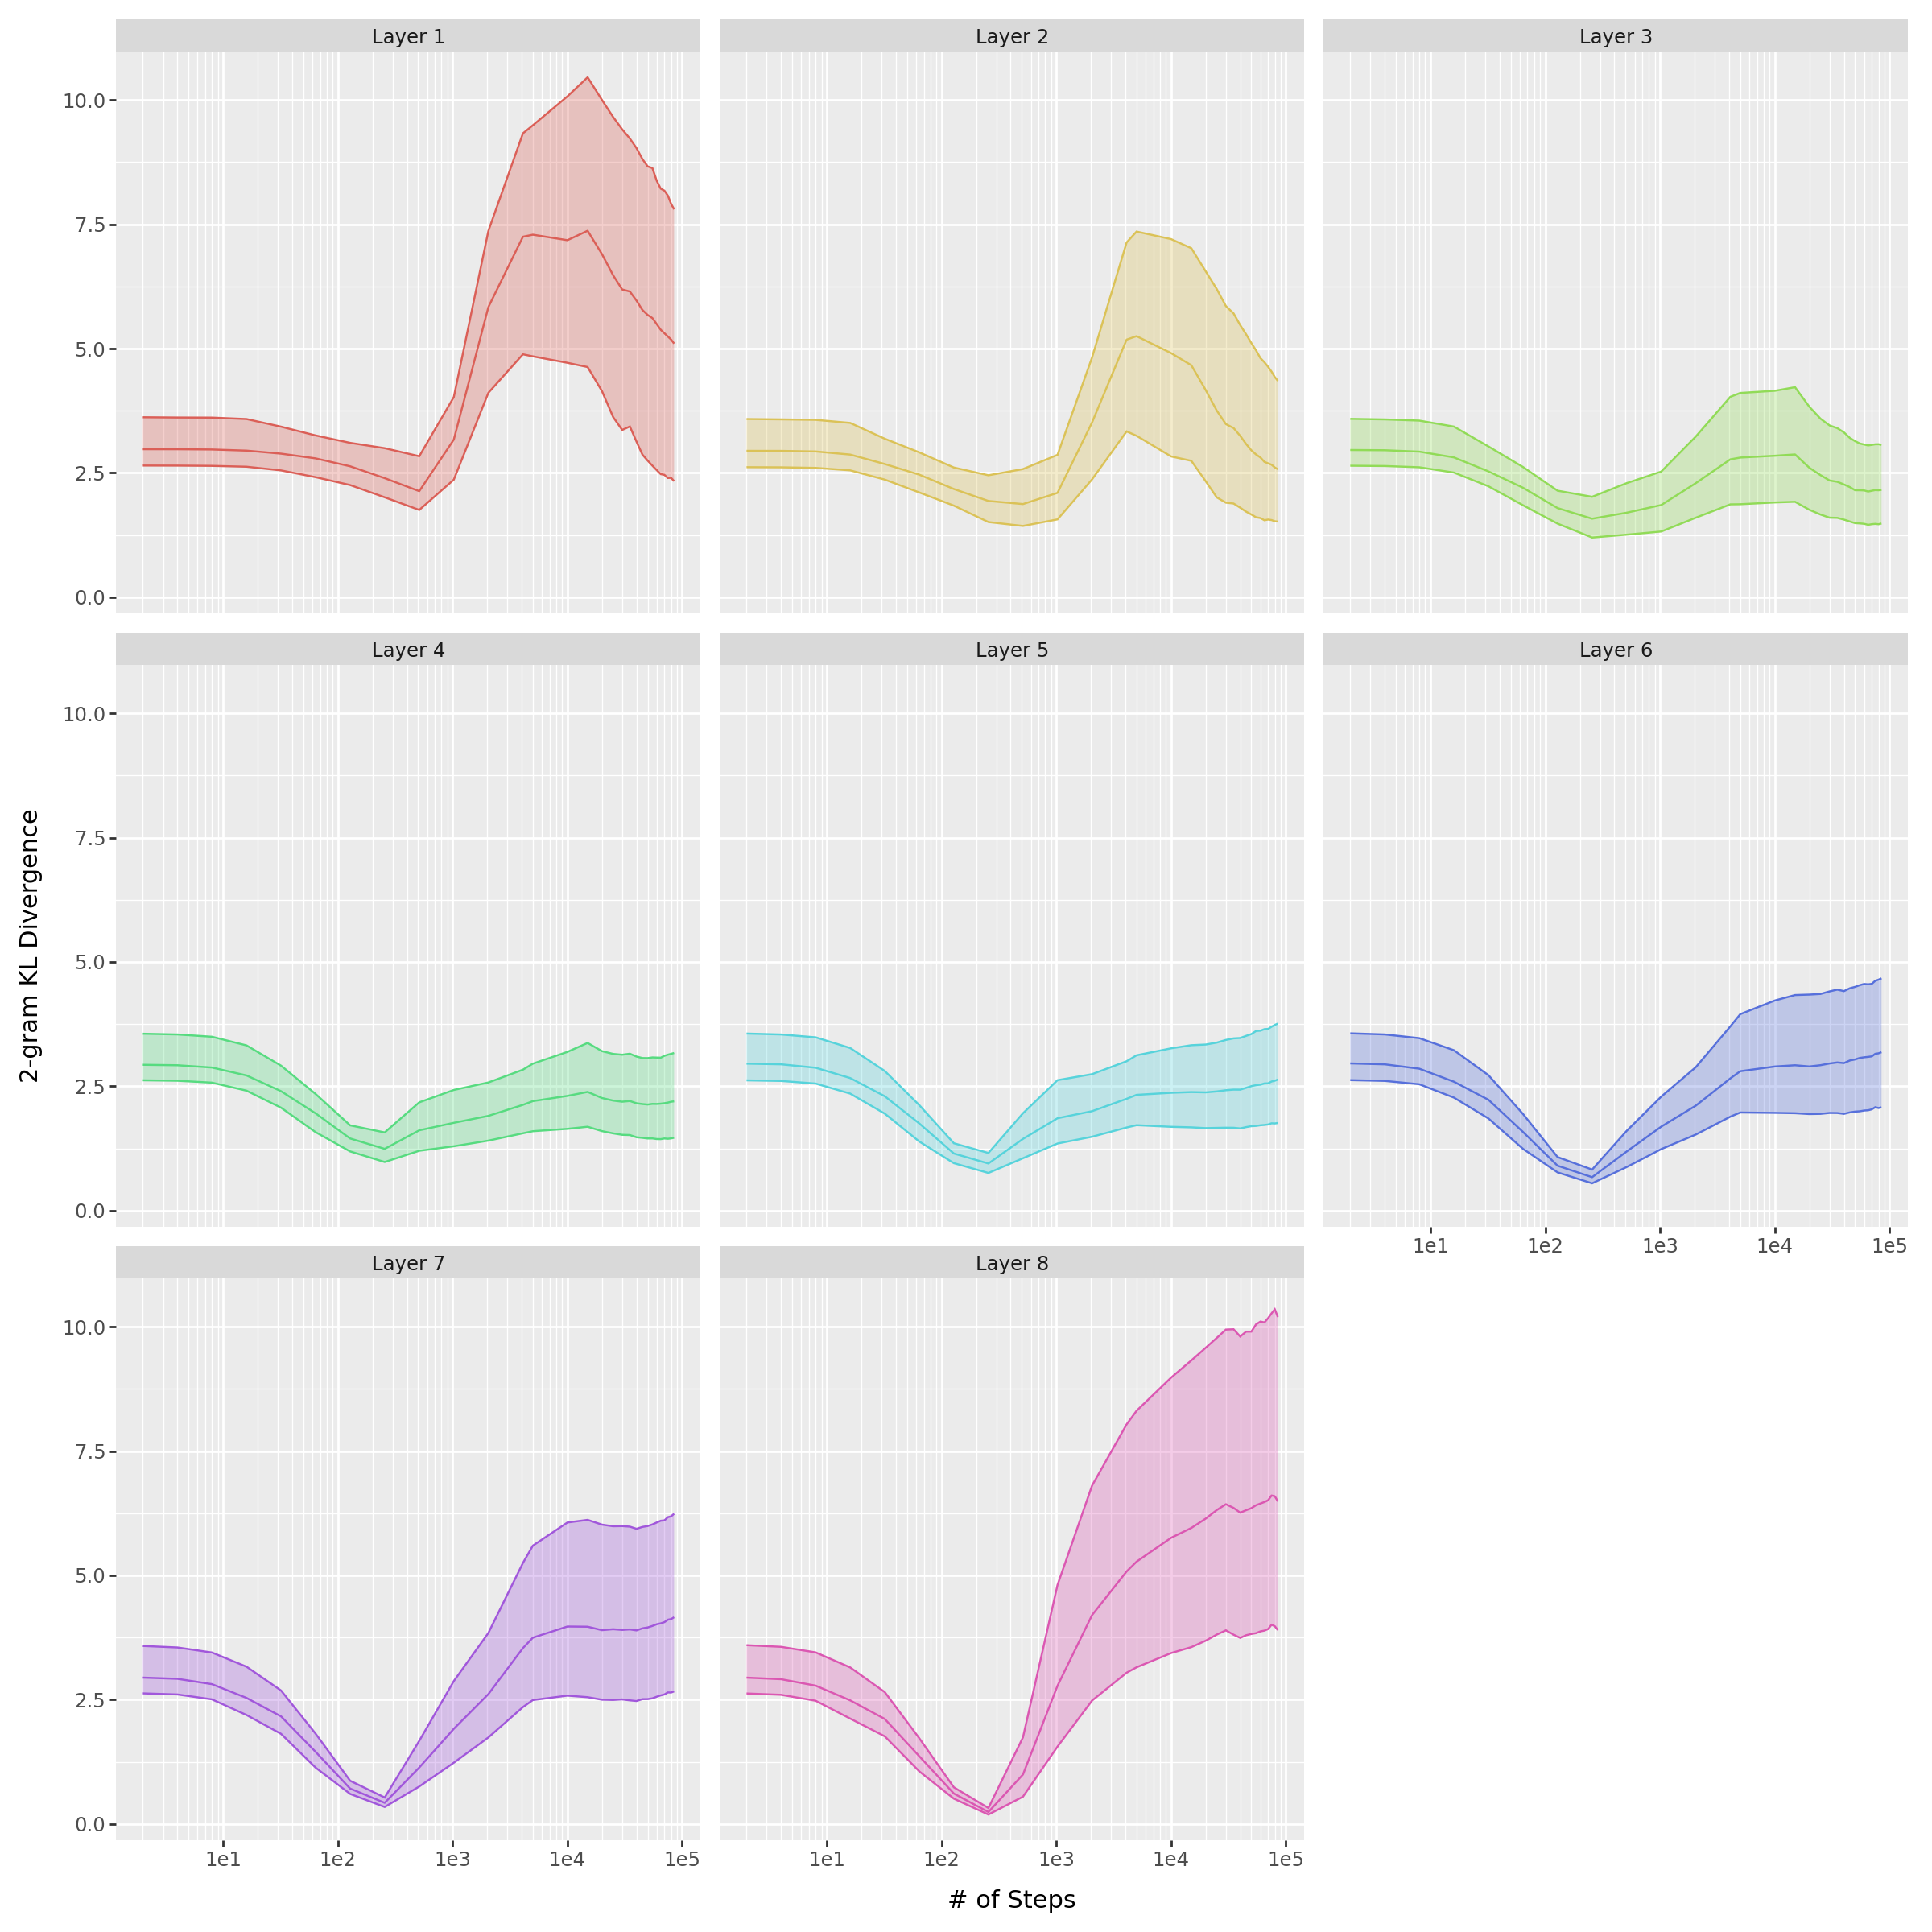

In [39]:
from plotnine import ggplot, geom_histogram, geom_boxplot, facet_wrap, labs, geom_line, geom_ribbon, scale_x_log10, scale_y_log10, theme
#layer_kl = estimate_layer_kl(model, 2, 64)
#bigram_df = pl.DataFrame(layer_kl).melt(variable_name='layer')
(
    ggplot(df.filter(pl.col('layers').ne('0')), aes(x='steps', y='kl_med', ymin='kl25', ymax='kl75', fill='layer_named', color='layer_named')) 
    + geom_line(show_legend=False) 
    + geom_ribbon(alpha=0.3, show_legend=False) 
    + scale_x_log10() 
    + facet_wrap('~layer_named')
    + labs(x = '# of Steps', y = '2-gram KL Divergence')
    + theme(figure_size = (12, 12))
)

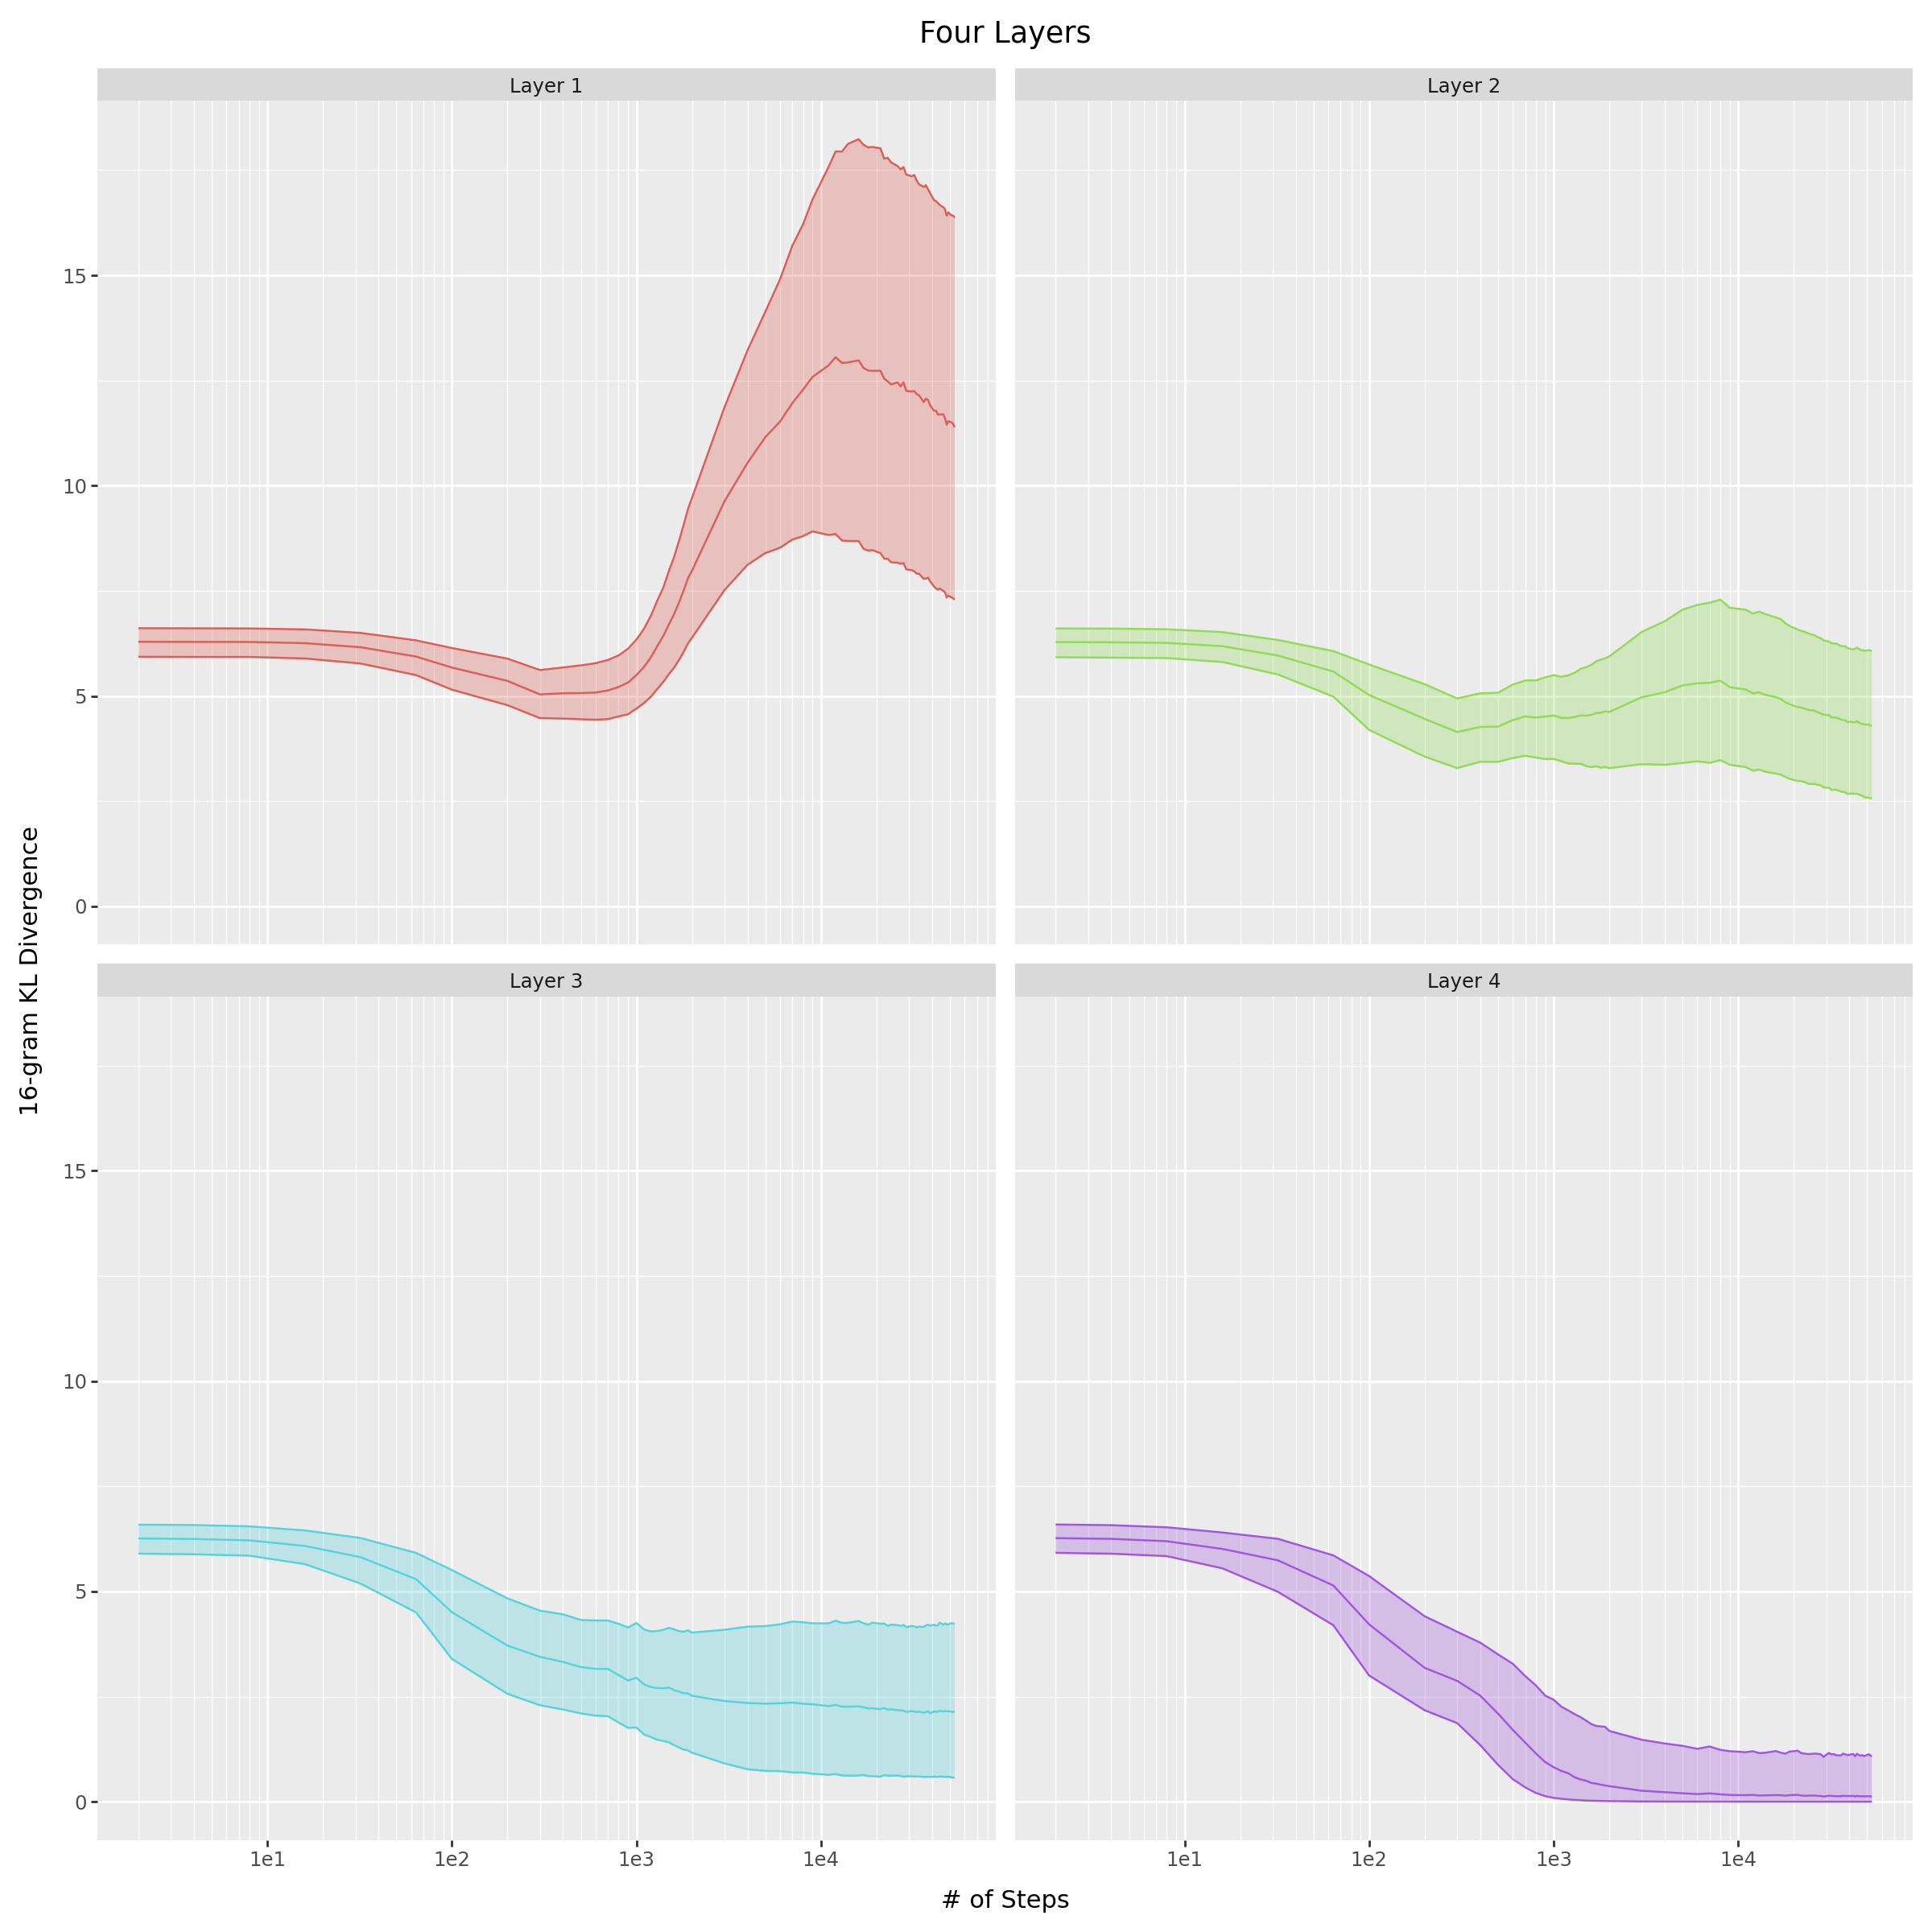

In [49]:
from plotnine import geom_ribbon

n = 16
df = (
    ngram_data4[n]
    .group_by(['layers', 'steps'])
    .agg(
        kl_mean = pl.col('value').mean(),
        kl_med = pl.col('value').median(),
        kl_std = pl.col('value').std(),
        kl10 = pl.col('value').quantile(0.10),
        kl25 = pl.col('value').quantile(0.25),
        kl75 = pl.col('value').quantile(0.75),
        kl90 = pl.col('value').quantile(0.90),
        kl_min = pl.col('value').min(),
        kl_max = pl.col('value').max(),
    )
    .with_columns(layer_named = 'Layer ' + pl.col('layers'))
    .collect()
)

(
    ggplot(df.filter(pl.col('layers').ne('0')), aes(x='steps', y='kl_med', ymin='kl25', ymax='kl75', fill='layer_named', color='layer_named')) 
    + geom_line(show_legend=False) 
    + geom_ribbon(alpha=0.3, show_legend=False) 
    + scale_x_log10() 
    + facet_wrap('~layer_named')
    + labs(x = '# of Steps', y = f'{n}-gram KL Divergence', title='Four Layers')
    + theme(figure_size = (12, 12))
)

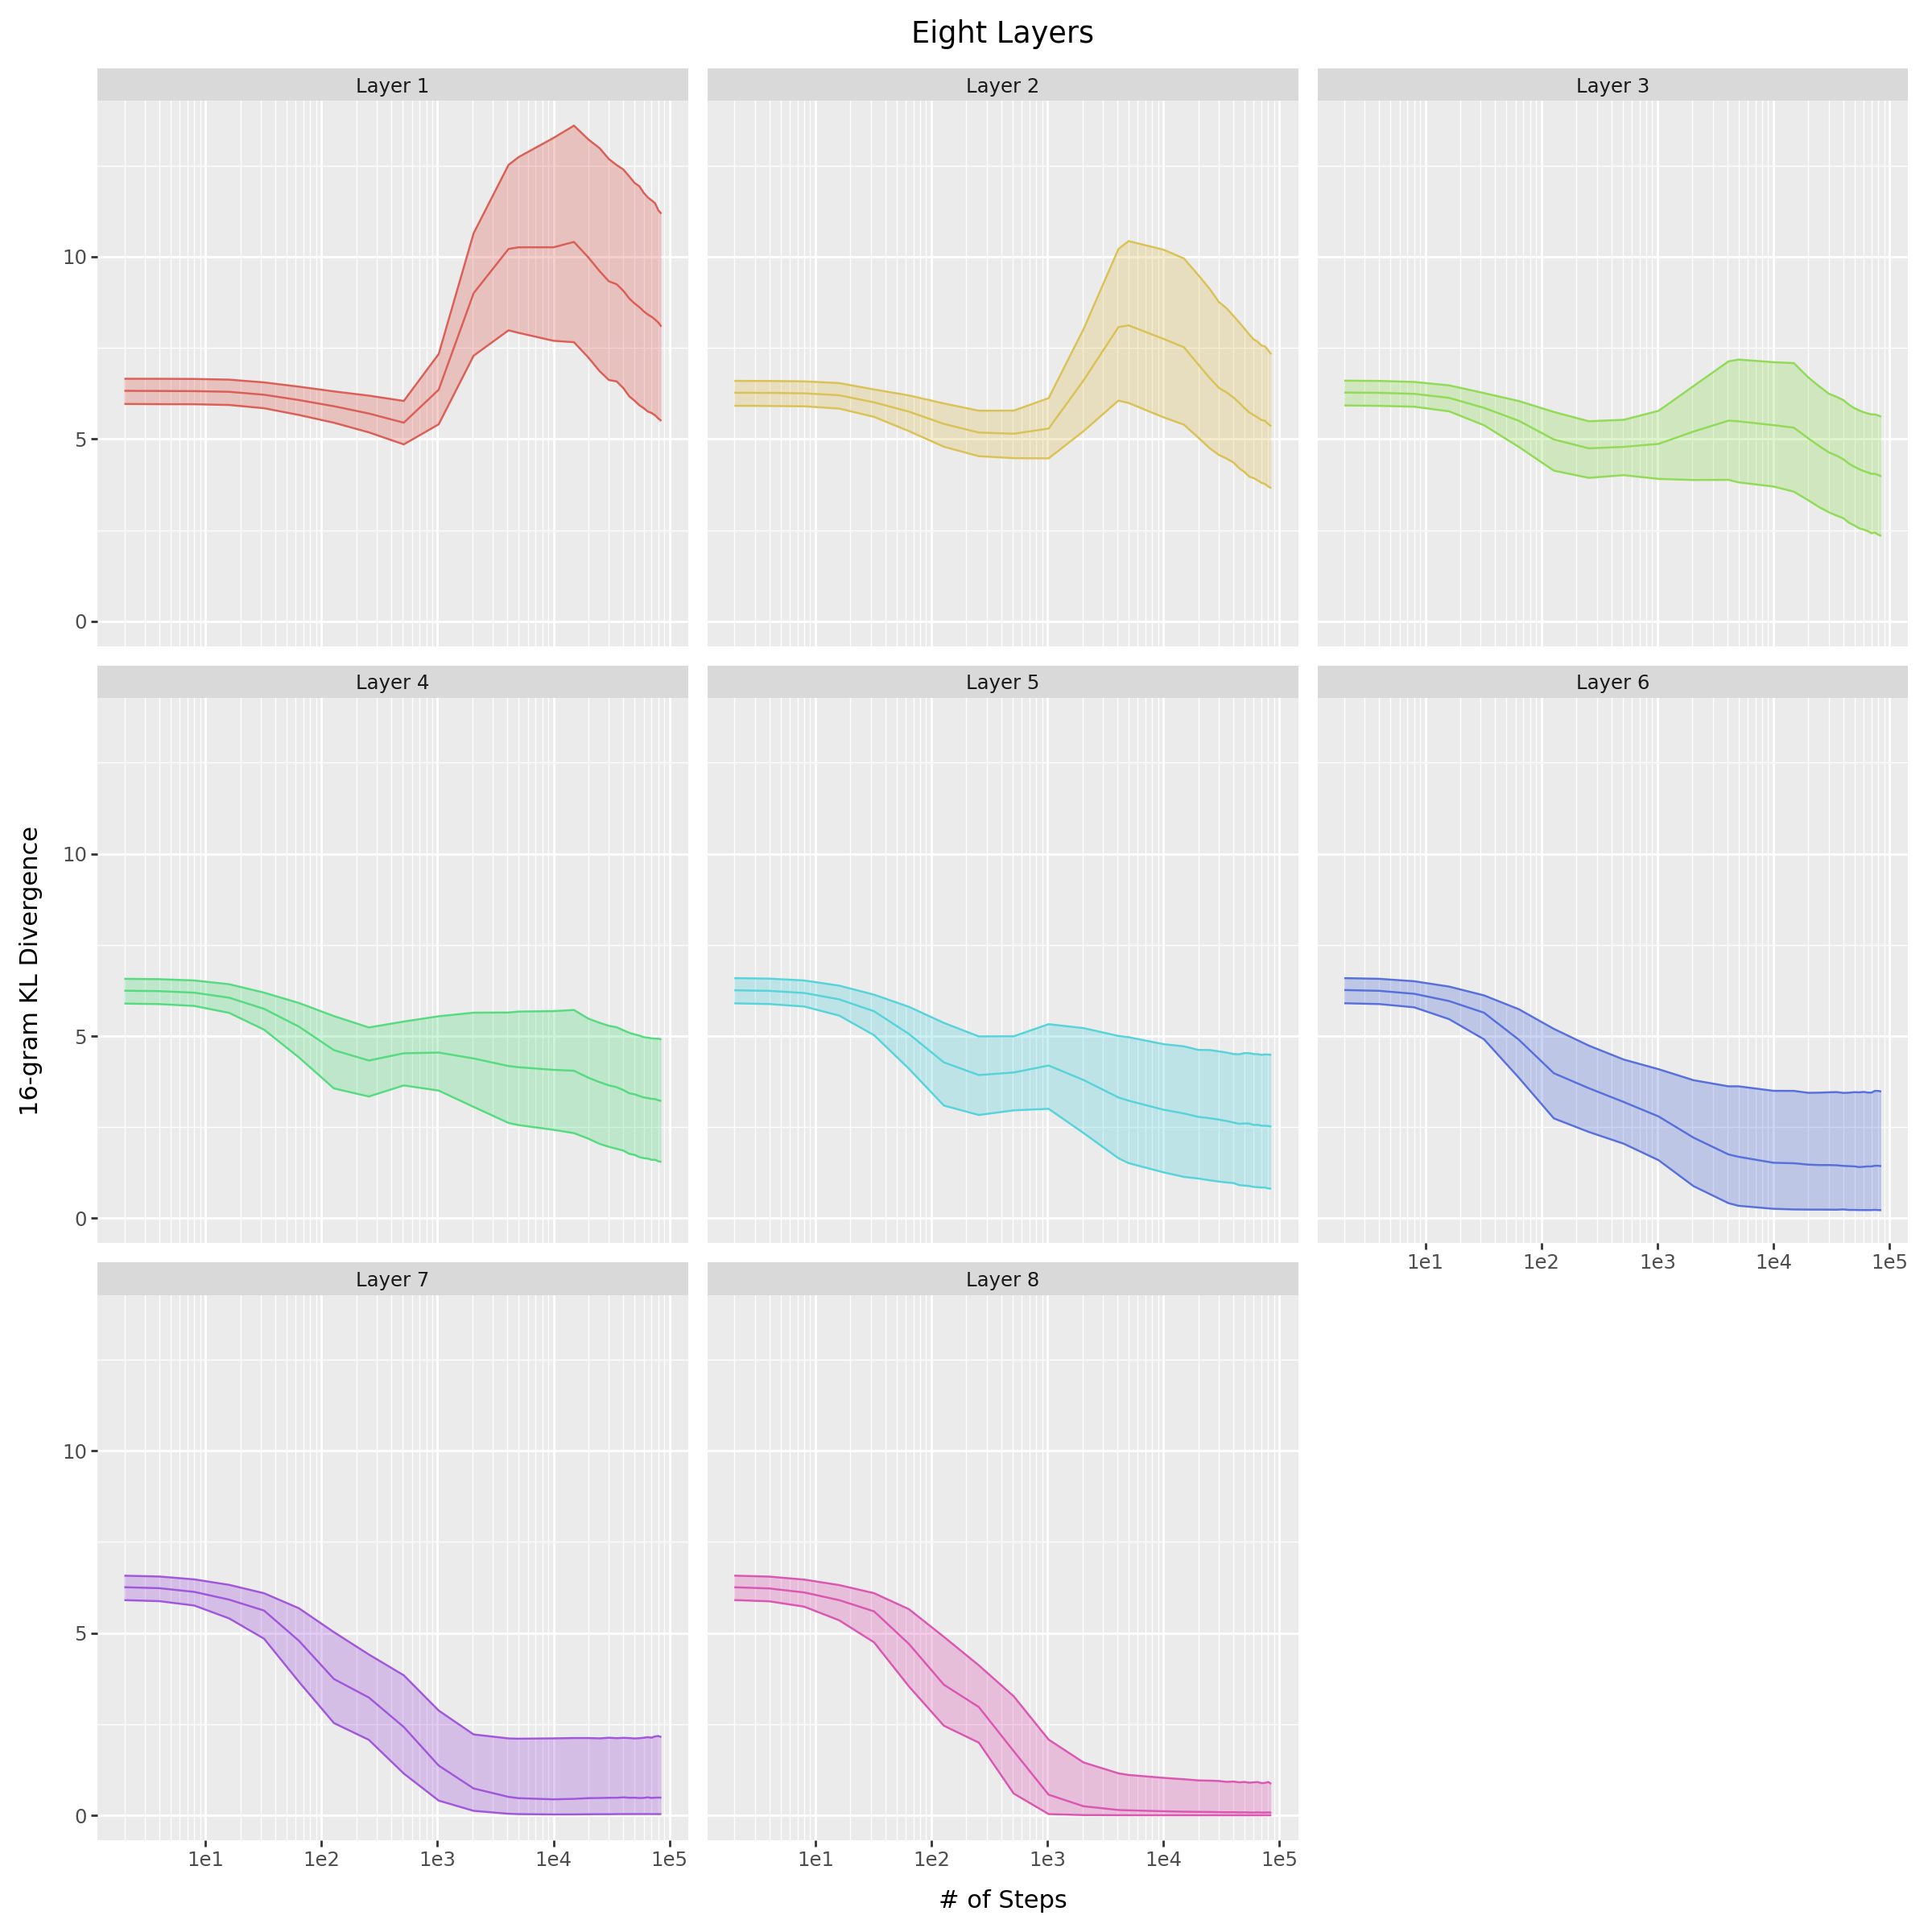

In [50]:
n = 16
df = (
    ngram_data8[n]
    .group_by(['layers', 'steps'])
    .agg(
        kl_mean = pl.col('value').mean(),
        kl_med = pl.col('value').median(),
        kl_std = pl.col('value').std(),
        kl10 = pl.col('value').quantile(0.10),
        kl25 = pl.col('value').quantile(0.25),
        kl75 = pl.col('value').quantile(0.75),
        kl90 = pl.col('value').quantile(0.90),
        kl_min = pl.col('value').min(),
        kl_max = pl.col('value').max(),
    )
    .with_columns(layer_named = 'Layer ' + pl.col('layers'))
    .collect()
)

(
    ggplot(df.filter(pl.col('layers').ne('0')), aes(x='steps', y='kl_med', ymin='kl25', ymax='kl75', fill='layer_named', color='layer_named')) 
    + geom_line(show_legend=False) 
    + geom_ribbon(alpha=0.3, show_legend=False) 
    + scale_x_log10() 
    + facet_wrap('~layer_named')
    + labs(x = '# of Steps', y = f'{n}-gram KL Divergence', title='Eight Layers')
    + theme(figure_size = (12, 12))
)

In [39]:
from functools import reduce, partial



def _join(variables, df1, df2):
    return df1.join(df2, on=variables)

join = partial(_join, ['layers', 'steps', 'kl_stat'])

def get_layer_data(ngram_data, n, layer_idx):
    df = (
        ngram_data[n]
        .filter(pl.col('layers').eq(str(layer_idx)))
        .group_by(['steps', 'layers'])
        .agg(
            kl_mean = pl.col('value').mean(),
            kl_med = pl.col('value').median(),
            kl_std = pl.col('value').std(),
            kl10 = pl.col('value').quantile(0.10),
            kl25 = pl.col('value').quantile(0.25),
            kl75 = pl.col('value').quantile(0.75),
            kl90 = pl.col('value').quantile(0.90),
            kl_min = pl.col('value').min(),
            kl_max = pl.col('value').max(),
        )
        .melt(id_vars=['layers', 'steps'], variable_name = 'kl_stat', value_name=f'{n}')
        .collect()
    )
    return df




layer4_df = reduce(join, [get_layer_data(ngram_data4, i, '4') for i in range(1, 17)]).melt(id_vars=['layers', 'steps', 'kl_stat'], variable_name='ngram')
layer8_df = reduce(join, [get_layer_data(ngram_data8, i, '8') for i in range(1, 21)]).melt(id_vars=['layers', 'steps', 'kl_stat'], variable_name='ngram')

In [40]:
layer4_df['steps'].unique()

steps
i32
2
4
8
16
32
…
48000
49000
51000


In [41]:
fmt_number = {
    '1': '01',
    '2': '02',
    '3': '03',
    '4': '04',
    '5': '05',
    '6': '06',
    '7': '07',
    '8': '08',
    '9': '09',
    
}
layer4_df = layer4_df.with_columns(pl.col('ngram').replace(fmt_number))
layer8_df = layer8_df.with_columns(pl.col('ngram').replace(fmt_number))

In [43]:
layer8_df.head()

layers,steps,kl_stat,ngram,value
str,i32,str,str,f32
"""8""",1024,"""kl_mean""","""01""",5.324849
"""8""",16,"""kl_mean""","""01""",0.691975
"""8""",20000,"""kl_mean""","""01""",10.858648
"""8""",25000,"""kl_mean""","""01""",10.564262
"""8""",5000,"""kl_mean""","""01""",9.711993


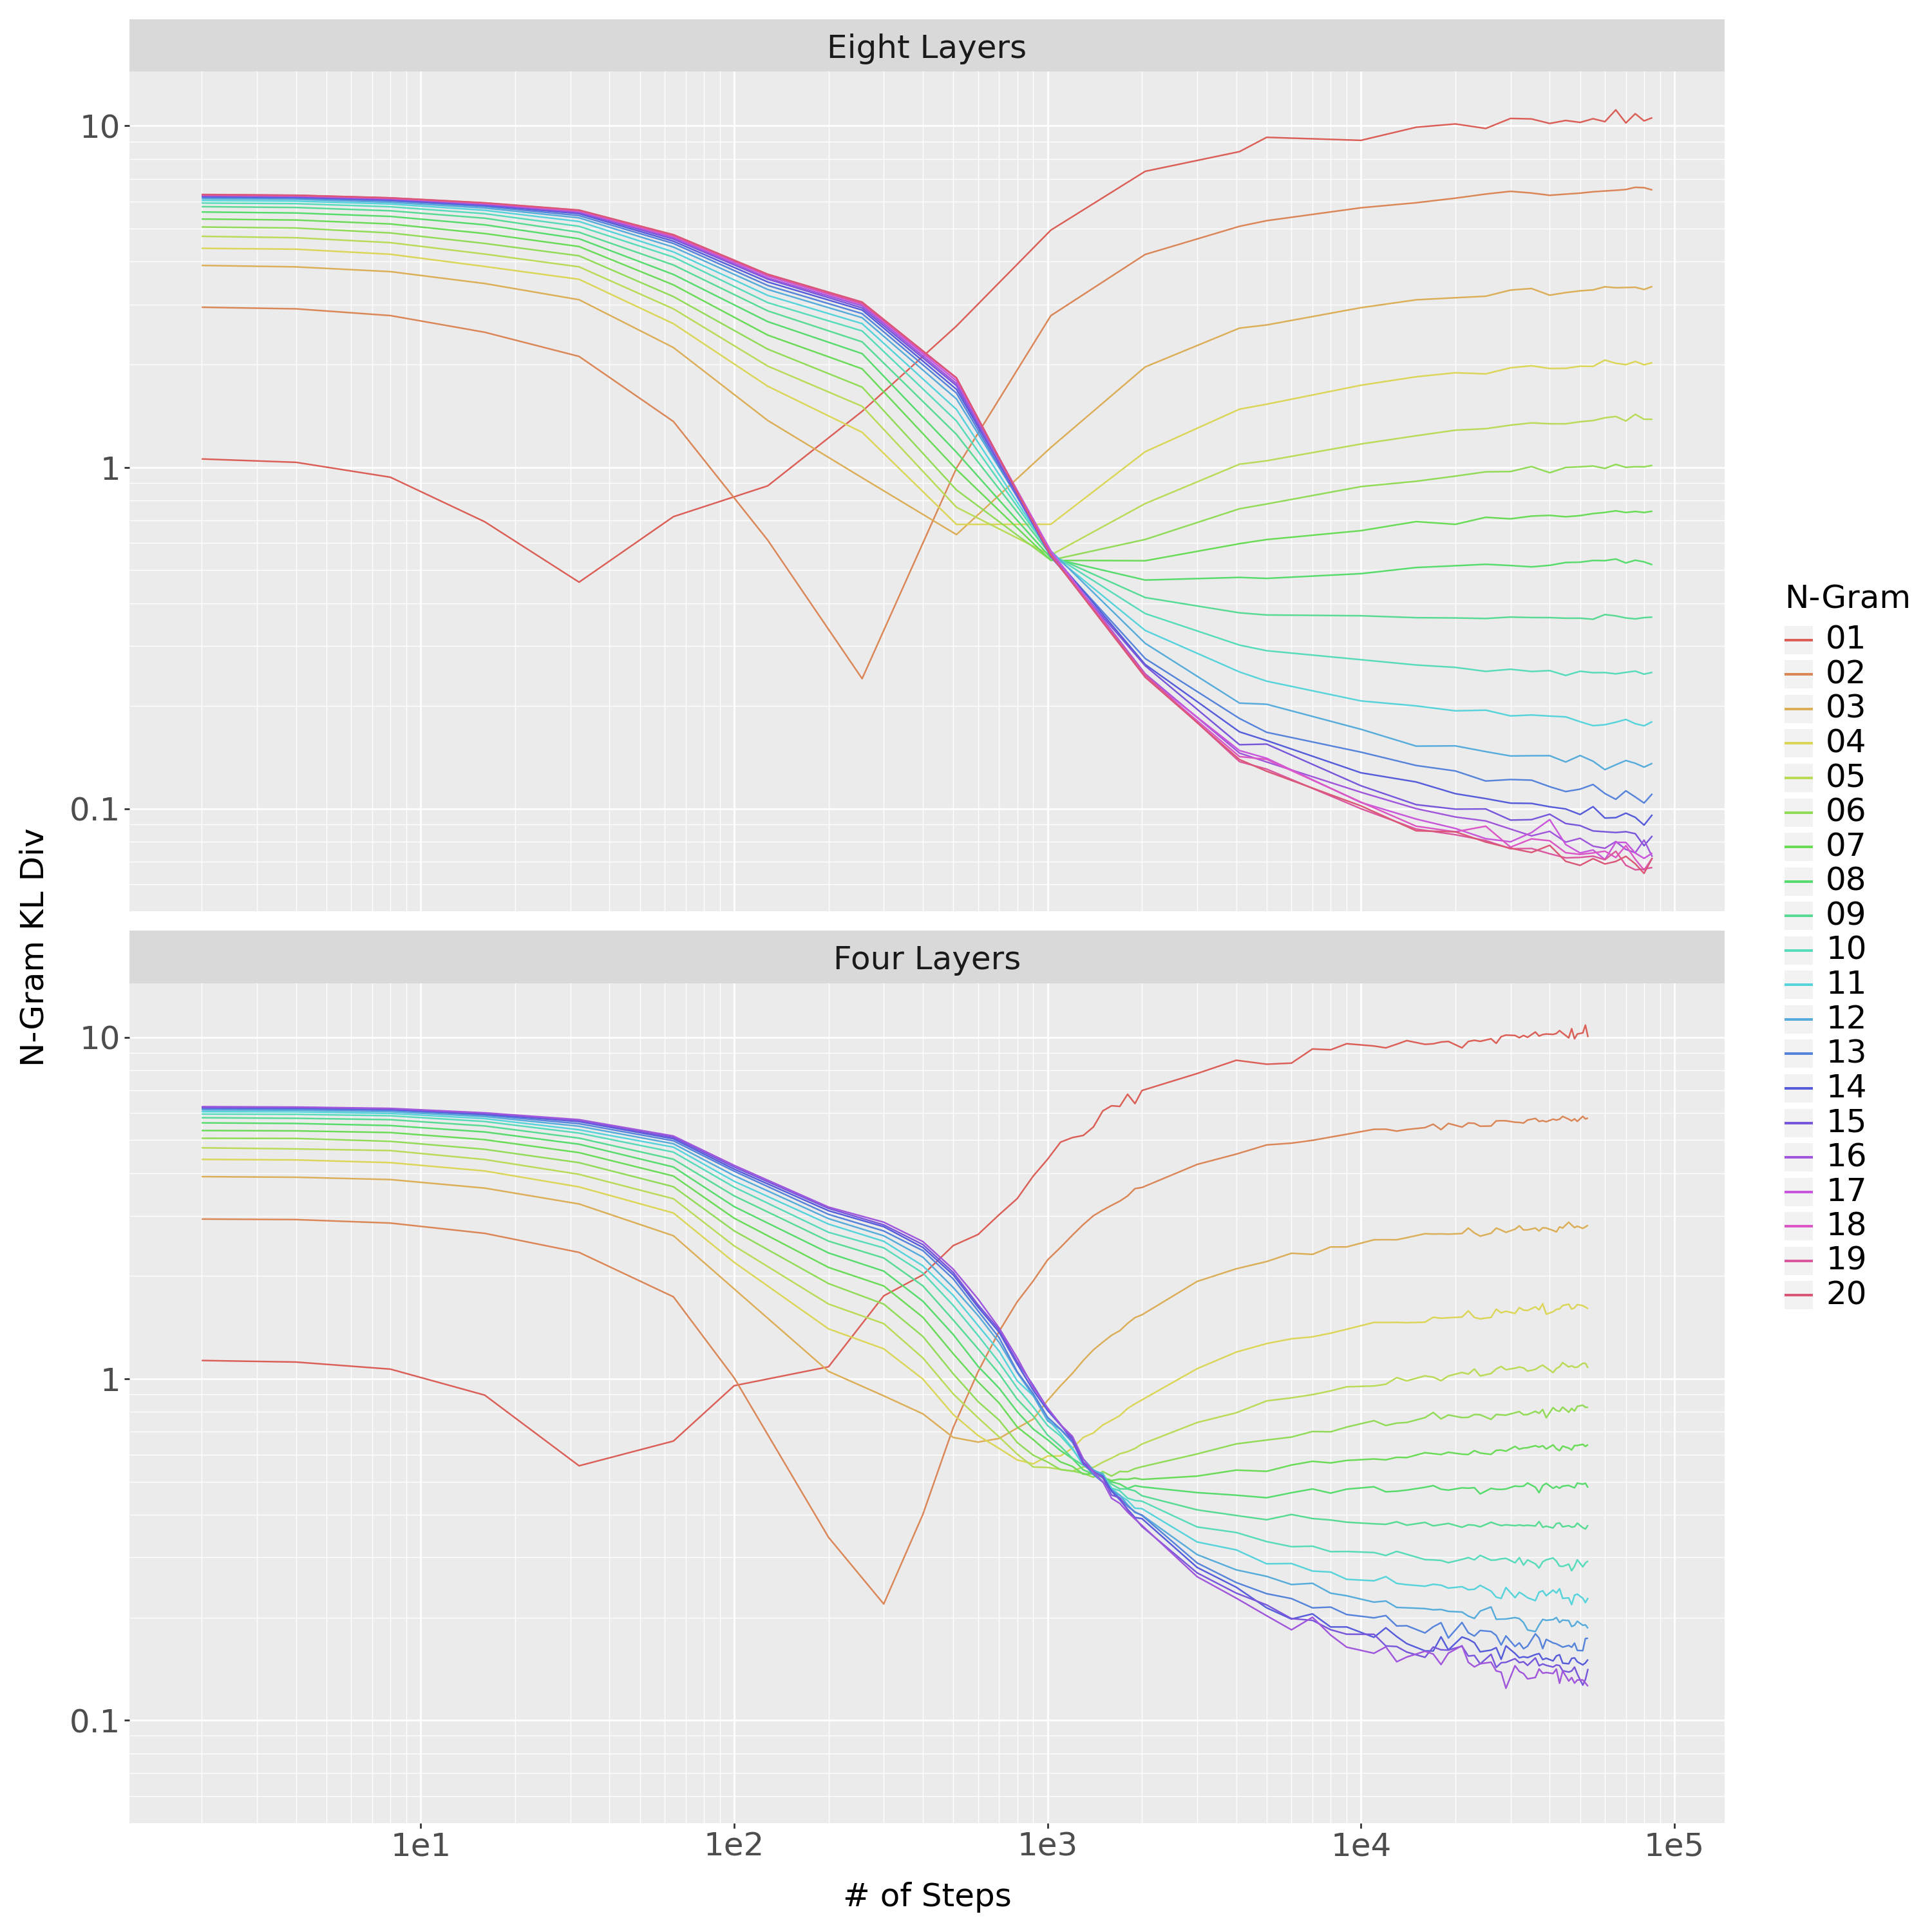

In [47]:
from plotnine import element_text, geom_line, scale_x_log10, scale_y_log10, theme, labs, facet_wrap

df = pl.concat([layer4_df.filter(pl.col('kl_stat').eq('kl_med')), layer8_df.filter(pl.col('kl_stat').eq('kl_med'))])
df = df.with_columns(model=pl.col('layers').replace({'4': 'Four Layers', '8': 'Eight Layers'}))
(
    ggplot(
        df,
        #layer8_df.filter(pl.col('kl_stat').eq('kl_med')), 
        aes(x='steps', y='value', color='ngram')) 
    + geom_line() 
    + scale_x_log10()
    + scale_y_log10()
    + facet_wrap('~model', ncol = 1)
    + labs(y = 'N-Gram KL Div', x = '# of Steps', color='N-Gram')
    + theme(figure_size = (15, 15), text = element_text(size=18))
)

In [159]:
layer_kl = estimate_layer_kl(model, 3, 64)
trigram_df = pl.DataFrame(layer_kl).melt(variable_name='layer')

/home/dashiell/workspace/ngram-markov/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


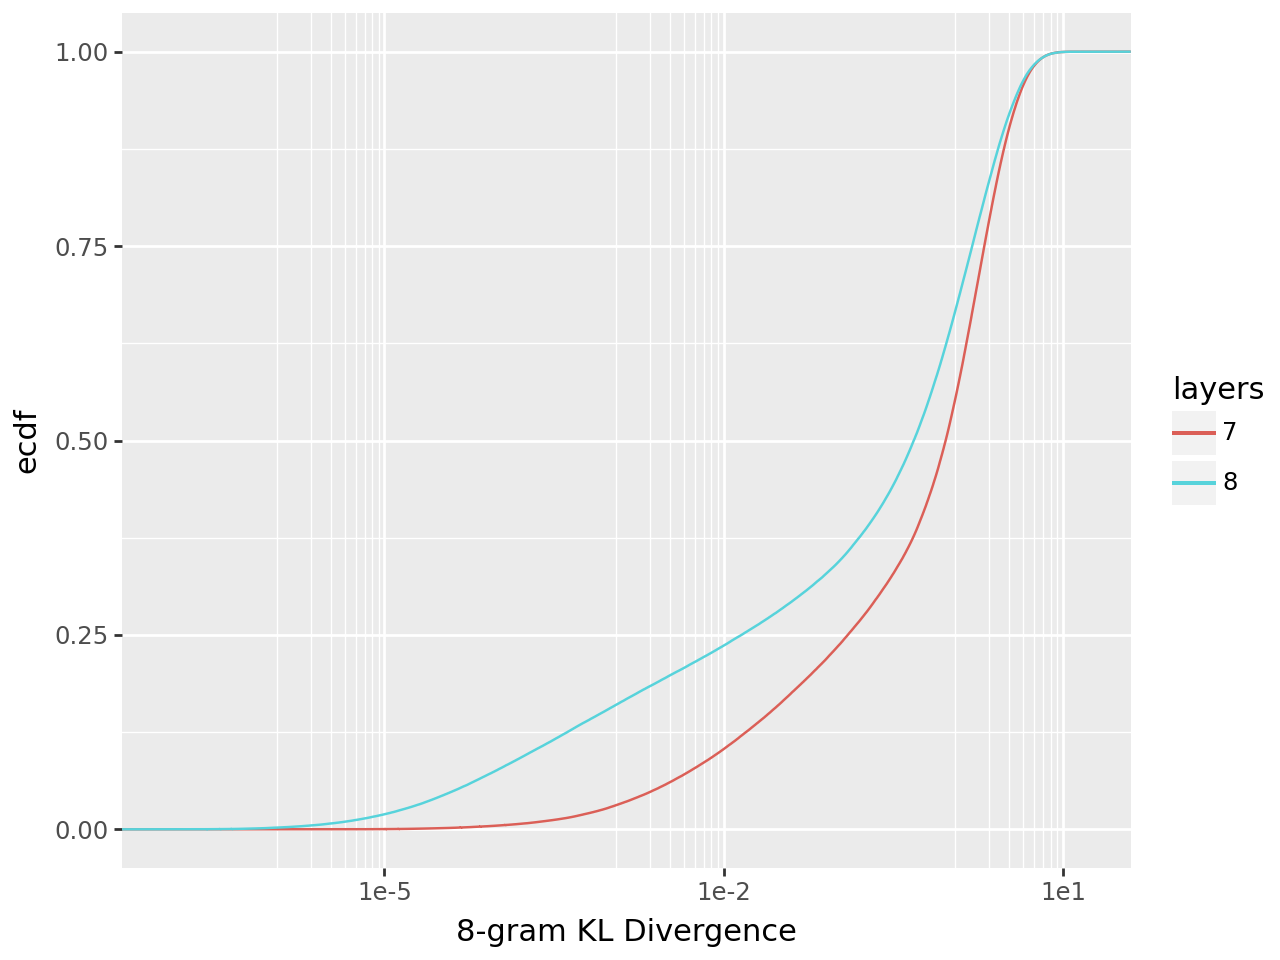

In [104]:
from plotnine import ggplot, geom_histogram, geom_boxplot, facet_wrap, labs, stat_ecdf

(
    ggplot(ngram_data[8].filter(pl.col('steps').eq(4096) & pl.col('layers').is_in(['7', '8'])), aes(x='value', color='layers'))
    + stat_ecdf(geom='step') 
    + scale_x_log10()
    + labs(x = '8-gram KL Divergence')
)

/home/dashiell/workspace/ngram-markov/.venv/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 212'. Pick better value with 'binwidth'.


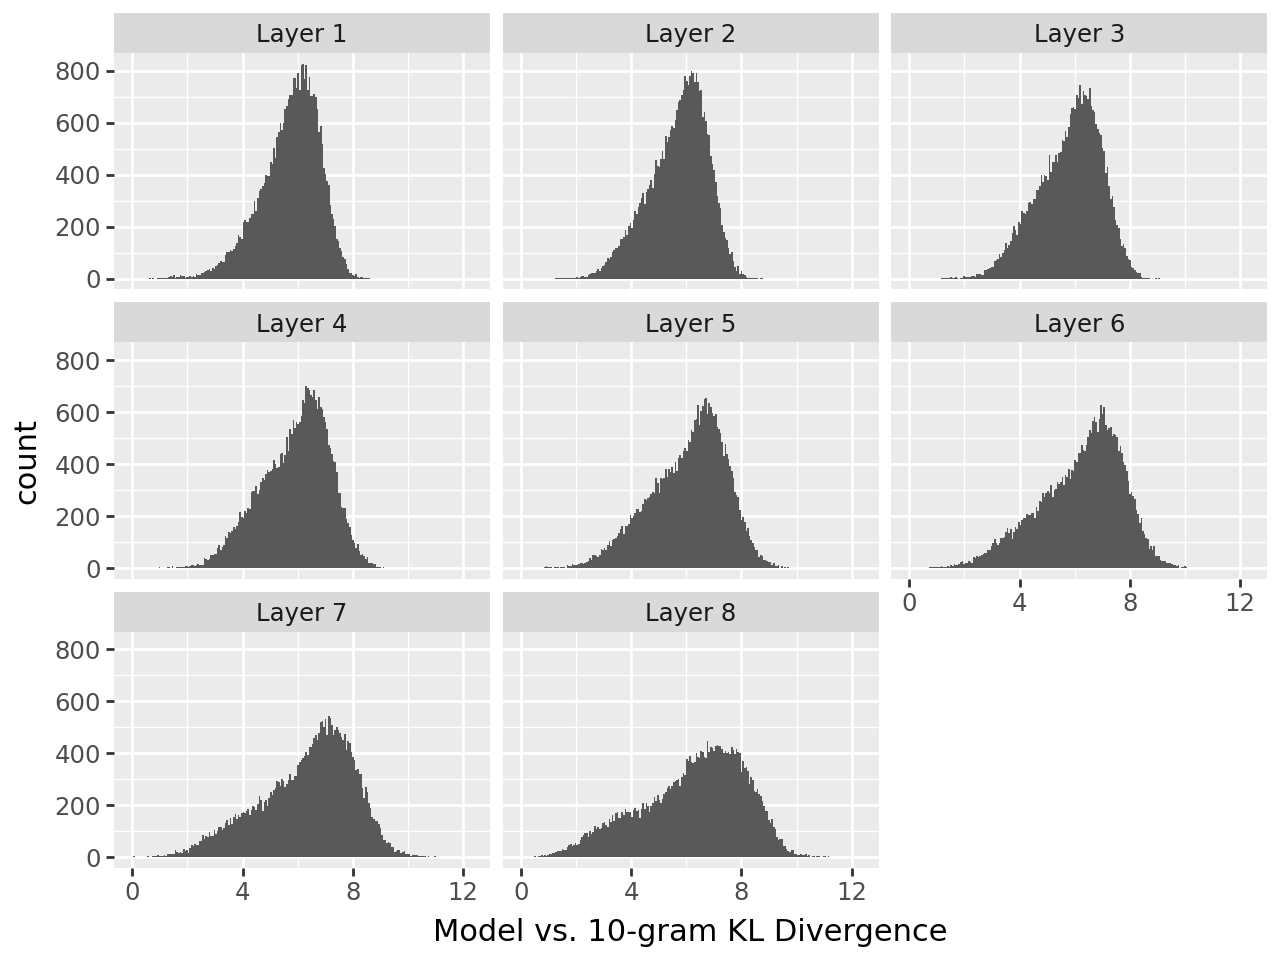

In [164]:
n = 10
layer_kl = estimate_layer_kl(model, n, 64)
ngram_df = pl.DataFrame(layer_kl).melt(variable_name='layer')
ggplot(ngram_df.filter(~pl.col('layer').eq('Layer 0')), aes(x='value')) + geom_histogram() + facet_wrap('~layer') + labs(x = f'Model vs. {n}-gram KL Divergence')

In [23]:
full_unigram_counts = np.array(unigrams, dtype=np.float32)

In [24]:
nonzero_unigrams = full_unigram_counts.sum(axis=0) != 0
unigram_counts = full_unigram_counts[nonzero_unigrams, :]
unigram_counts = unigram_counts[:, nonzero_unigrams]

In [25]:
unigram_counts.shape

(407, 407)

In [26]:
transition_mat = unigram_counts / unigram_counts.sum(axis=0)[:, None]

In [28]:
T, Z = linalg.schur(transition_mat)

In [38]:
queries = []

for i in range(512):
    following = np.argwhere(full_unigram_counts[1] != 0).squeeze().tolist()
    queries += [[i, j] for j in following]

In [59]:
queries[0:5]

[[0, 0], [0, 1], [0, 7], [0, 9], [0, 10]]

In [43]:
bigram_counts = index.batch_count_next(queries, 511)

In [49]:
bigram_counts = np.array(bigram_counts, dtype=np.float32)

In [166]:
four_grams_mat = IncrementalCSRMatrix((512**2, 512), np.float32)

for bigrams, counts in zip(queries, bigram_counts):
    index = bigrams[0] * 512 + bigrams[1]
    four_grams_mat.append_row(counts, index)

In [65]:
three_grams = four_grams_mat.tocsr()

In [72]:
nz_threegrams = np.argwhere(three_grams.sum(axis=1) != 0).squeeze()

In [201]:
512 ** 4

68719476736

In [13]:
def get_base_512(x: int, minlen=2):
    curr_val, mod = divmod(x, 512)
    nums = [mod]
    while True:
        if curr_val < 512:
            nums.insert(0, curr_val)
            break
        else:
            curr_val, mod = divmod(curr_val, 512)
            nums.insert(0, mod)
    need_extras = minlen - len(nums)
    if need_extras > 0:
        extras = [0] * need_extras
        nums = extras + nums
    return nums


In [14]:
import torch

def create_ngrams(tensor, n):
    assert n >= 1
    stride = tensor.stride()
    size = tensor.size()

    # Create a new stride that moves by 1 element in the original tensor
    new_stride = (stride[0], stride[0])

    # Calculate the new shape of the tensor
    new_size = (size[0] - n + 1, n)

    # Use as_strided to create a new view of the tensor with the desired shape and stride
    ngrams = torch.as_strided(tensor, size=new_size, stride=new_stride)
    return ngrams

# Example usage
tensor = torch.tensor(list(range(1024)))
triplets = create_ngrams(tensor, 4)
print(triplets.shape)  # Output: torch.Size([1022, 3])
print(triplets[:5])   # Output: tensor([[0, 1, 2],
                      #                 [1, 2, 3],
                      #                 [2, 3, 4],
                      #                 [3, 4, 5],
                      #                 [4, 5, 6]])

torch.Size([1021, 4])
tensor([[0, 1, 2, 3],
        [1, 2, 3, 4],
        [2, 3, 4, 5],
        [3, 4, 5, 6],
        [4, 5, 6, 7]])


In [2]:
from ngram_markov.model import GPTConfig, GPT

config = GPTConfig()

In [3]:
model = GPT(config)

number of parameters: 6.56M


In [17]:
import torch

tokens = torch.randint(512, (32, 1024))
logits, _ = model(tokens)

In [6]:
import torch
import scipy.sparse as sp

def kl_divergence(log_p, log_q):
    return torch.sum(torch.exp(log_p) * (log_p - log_q), dim=-1)

def create_ngrams(tensor, n):
    assert n >= 1
    stride = tensor.stride()
    size = tensor.size()

    # Create a new stride that moves by 1 element in the original tensor
    new_stride = (stride[0], stride[1], stride[1])

    # Calculate the new shape of the tensor
    new_size = (size[0], size[1] - n + 1, n)

    # Use as_strided to create a new view of the tensor with the desired shape and stride
    ngrams = torch.as_strided(tensor, size=new_size, stride=new_stride)
    return ngrams

def calculate_ngram_kl_divergence(model, tokens, ngrams, n):
    # Get the model's logits
    with torch.no_grad():
        logits, _ = model(tokens)

    # Get the n-grams from the tokens
    ngrams_tensor = create_ngrams(tokens, n-1)

    # Convert n-grams to indices for accessing the sparse matrix
    vocab_size = ngrams.shape[1]
    exponents = vocab_size **  torch.flip(torch.arange(n - 1, device=tokens.device).view(1, 1, -1), [-1])
    indices = torch.sum(ngrams_tensor * exponents, dim=-1)

    # Get the n-gram distributions from the sparse matrix
    ngram_distributions = torch.tensor(ngrams[indices.view(-1).numpy()].toarray(), device=tokens.device)
    ngram_distributions = ngram_distributions.view(tokens.shape[0], tokens.shape[1] - n + 2, vocab_size)

    log_ngram_probs = torch.log(ngram_distributions + 1e-10)  # Add a small epsilon to avoid log(0)
    log_model_probs = torch.log_softmax(logits[:, n-2:].contiguous(), dim=-1)
    


    # Calculate the KL divergence between the n-gram distributions and the model's logits
    kl_div = kl_divergence(log_ngram_prbs, log_model_probs)

    return kl_div

# Example usage
batch_size = 32
seq_length = 100
vocab_size = 512
n = 3  # n-gram size

# Create a random batch of tokens
tokens = torch.randint(0, vocab_size, (batch_size, seq_length))

# Create a random sparse matrix for n-grams
ngrams = sp.random(vocab_size ** (n - 1), vocab_size, density=0.1, format='csr')

# Assuming you have a pre-trained model

# Calculate the KL divergence between the n-gram distributions and the model's logits
kl_div = calculate_kl_divergence(model, tokens, ngrams, n)
print(kl_div.shape)  # Output: torch.Size([32, 98])

torch.Size([32, 99])


In [40]:
create_ngrams(tokens, n-1).shape

torch.Size([32, 99, 2])

In [7]:
kl_div

tensor([[52.5670, 53.4541, 43.4771,  ..., 35.1023, 69.0282, 41.1461],
        [44.8973, 49.1424, 44.5436,  ..., 44.2051, 35.5728, 43.0134],
        [58.1959, 57.7971, 48.1693,  ..., 67.9263, 39.2092, 37.8521],
        ...,
        [49.4459, 50.9239, 64.3511,  ..., 48.8548, 56.3458, 46.9501],
        [66.3965, 31.6690, 66.8431,  ..., 72.1195, 49.8303, 37.4925],
        [53.6774, 60.6078, 44.7250,  ..., 37.0304, 54.8252, 63.7891]],
       dtype=torch.float64)

In [79]:
ts_bin_path = 'scripts/train.bin'


index = MemmapIndex(
    ts_bin_path,
    "data/train_ngram_index.idx",
)

FileNotFoundError: No such file or directory (os error 2)

In [80]:
three_grams[[11], :].nonzero()

NameError: name 'three_grams' is not defined

In [105]:
from copy import deepcopy

fourgram_queries = []

for i in nz_threegrams.tolist():
    tokens = get_base_512(i)
    
    _, following = three_grams[[i], :].nonzero()
    fourgram_queries += [deepcopy(tokens) + [j] for j in following.tolist()]

In [107]:
len(fourgram_queries)

633847

In [113]:
fourgram_raw_counts = np.array(index.batch_count_next(fourgram_queries, 511), dtype=np.float32)

In [190]:
fourgrams_mat = IncrementalCSRMatrix((512**3, 512), np.float32)
sparse_indices = []
dense_indices = []


for i, (tokens, counts) in enumerate(zip(fourgram_queries, fourgram_raw_counts)):
    idx = (tokens[0] * 512**2) + (tokens[1] * 512) + tokens[2] 
    if np.any(counts > 0):
        sparse_indices.append(idx)
        dense_indices.append(i)
        fourgrams_mat.append_row(counts, idx)

In [184]:
fourgrams_counts = fourgrams_mat.tocsr()

In [130]:
get_base_512(10939, minlen=3)

[0, 21, 187]

In [135]:
#index.count_next([0, 21, 187], 511)

[0, 21, 187] in fourgram_queries

False

In [177]:
tokens = fourgram_queries[1809]
idx = (tokens[0] * 512**2) + (tokens[1] * 512) + tokens[2] 

In [178]:
fourgrams_counts

<134217728x512 sparse array of type '<class 'numpy.float32'>'
	with 171433 stored elements in Compressed Sparse Row format>

In [200]:
import random

idx = random.randint(0, len(dense_indices))
dense = fourgram_raw_counts[dense_indices[idx], :]
sparse = fourgrams_counts[[sparse_indices[idx]], :].todense()
np.allclose(dense, sparse)

True

In [194]:
sparse

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

In [193]:
dense

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [181]:
fourgram_raw_counts[1809]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [172]:
fourgrams_counts[[idx], :].todense()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [137]:
np.argwhere(fourgram_raw_counts[:, 1] == 3)

array([[  7972],
       [138479],
       [138695],
       [142803],
       [148813],
       [149624],
       [150373],
       [153798],
       [165201],
       [169298],
       [169484],
       [172486],
       [181953],
       [186835],
       [201193],
       [201378],
       [201415],
       [208791],
       [208943],
       [219068],
       [219257],
       [221347],
       [225869],
       [226324],
       [228911],
       [229078],
       [229701],
       [233684],
       [235126],
       [238321],
       [241073],
       [241212],
       [241647],
       [241689],
       [242311],
       [242774],
       [244927],
       [245338],
       [252772],
       [253137],
       [256693],
       [275368],
       [276646],
       [281362],
       [281439],
       [282105],
       [287935],
       [289925],
       [297767],
       [301511],
       [307666],
       [307736],
       [315354],
       [326134],
       [328355],
       [329872],
       [338664]])

In [123]:
fourgrams_counts[[10939], :].todense()

array([[0.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00, 1.3000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

/Users/dashiell/workspace/ngram-markov/.venv/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 112'. Pick better value with 'binwidth'.
/Users/dashiell/workspace/ngram-markov/.venv/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 112'. Pick better value with 'binwidth'.


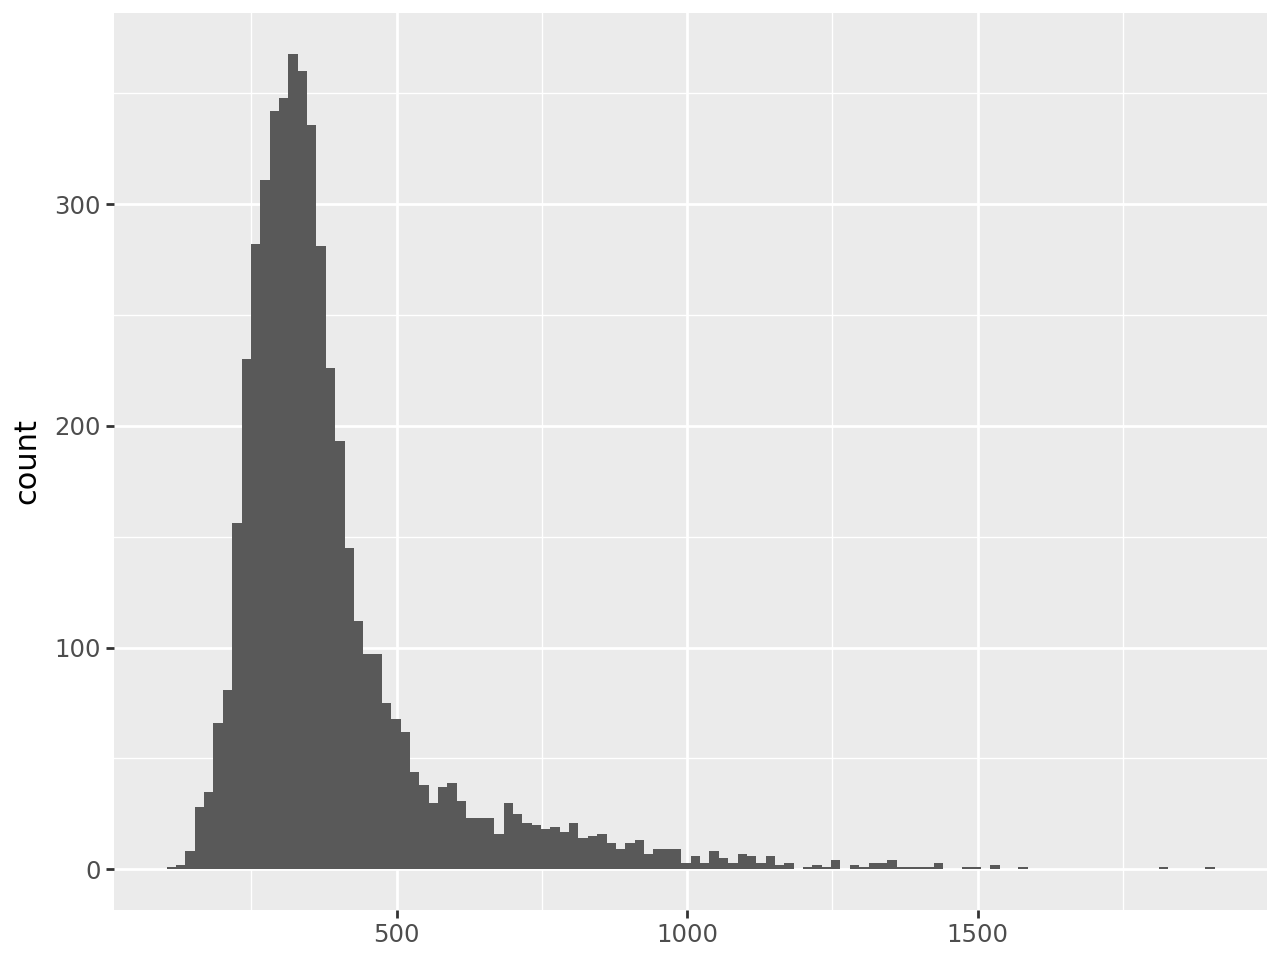

In [28]:
from plotnine import geom_histogram

qplot(x=lengths) + geom_histogram()

In [4]:
import pickle
from pathlib import Path

ngram_path = Path('pythia-deduped-bigrams.zst')

decomp = zstd.ZstdDecompressor()

with open(ngram_path, mode='rb') as file:
    raw_data = decomp.decompress(file.read())

In [5]:
bigrams = pickle.loads(raw_data)

<50277x50277 sparse array of type '<class 'numpy.uint32'>'
	with 486734660 stored elements in Compressed Sparse Row format>

/Users/dashiell/workspace/ngram-markov/.venv/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 305'. Pick better value with 'binwidth'.
/Users/dashiell/workspace/ngram-markov/.venv/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 305'. Pick better value with 'binwidth'.


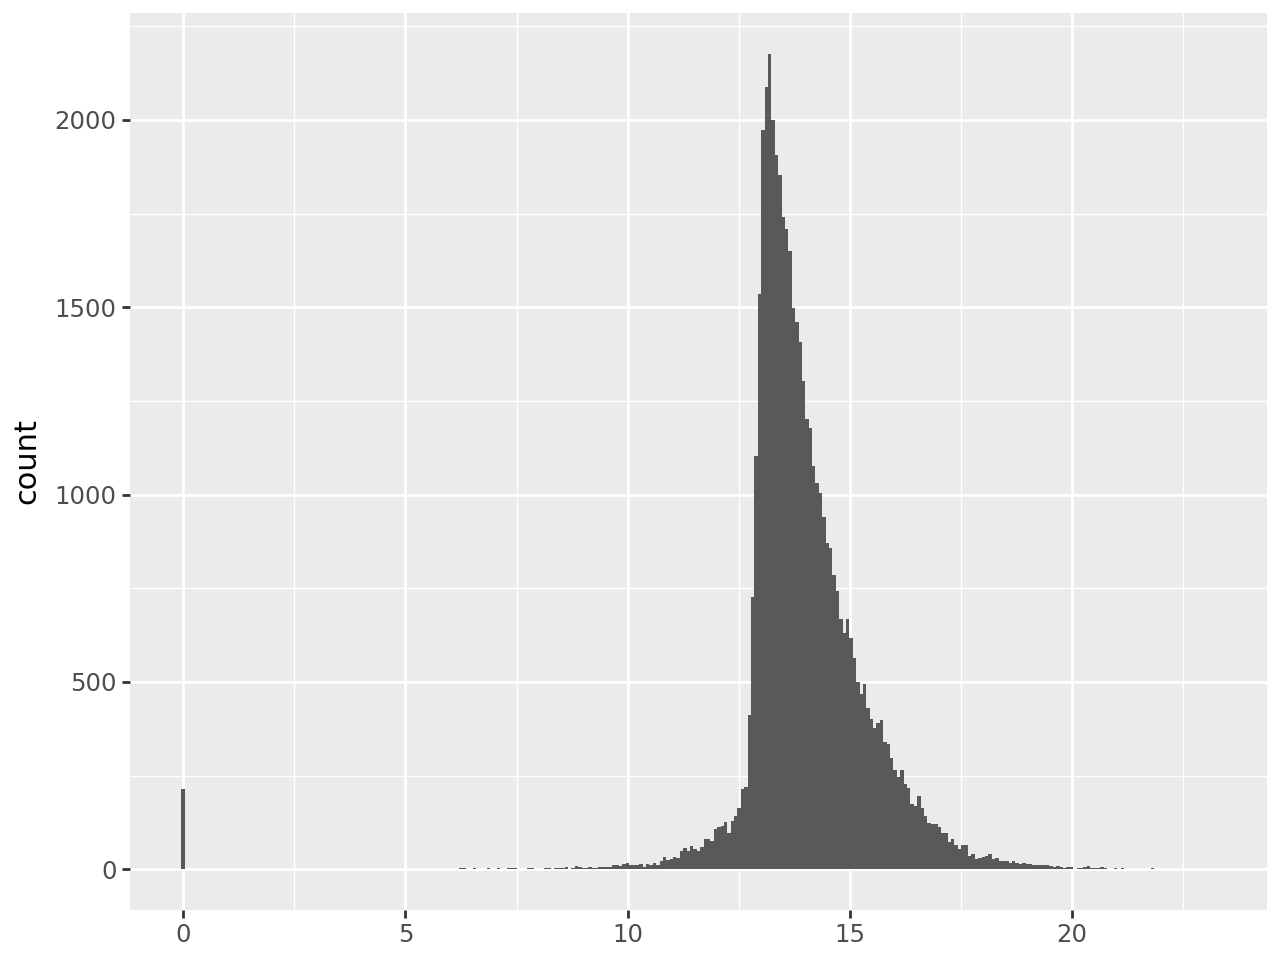

In [7]:
from plotnine import geom_histogram

transitions_from = np.sum(bigrams, axis=0)
qplot(x=np.log(1 + transitions_from)) + geom_histogram()

In [8]:
token_counts = pl.DataFrame({'occurrences': transitions_from}).with_row_index()

In [9]:
df = (
    token_counts
    .with_columns(
        pl.col('occurrences').rank(descending=True).alias('rank'),
        (pl.col('occurrences') + 1).log().alias('log_occurrences')
    )
    .with_columns(pl.col('rank').log().alias('log_rank'))
)

In [10]:
df.filter(pl.col('rank').lt(10))

index,occurrences,rank,log_occurrences,log_rank
u32,u64,f64,f64,f64
13,9362638615,3.0,22.959993,1.098612
14,2965935634,9.0,21.810458,2.197225
15,10346382453,2.0,23.059903,0.693147
187,11740996961,1.0,23.186353,0.0
247,3312842838,8.0,21.921073,2.079442
253,8485755698,4.0,22.861655,1.386294
273,4746582725,5.0,22.280691,1.609438
281,4084327341,7.0,22.130423,1.94591
285,4201626736,6.0,22.158738,1.791759


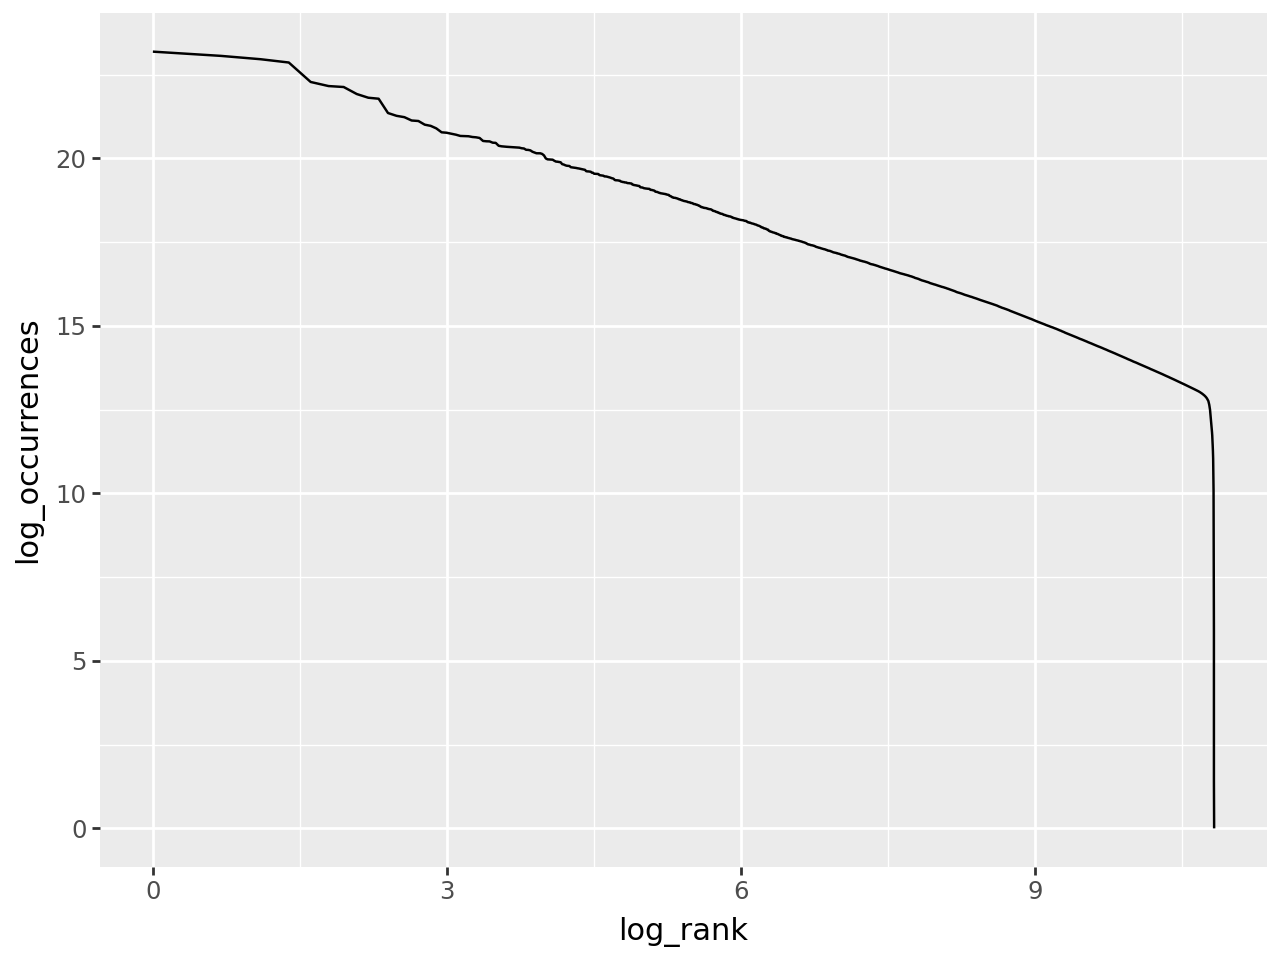

In [20]:
from plotnine import geom_line

ggplot(df, aes(x = 'log_rank', y='log_occurrences')) + geom_line()

/Users/dashiell/workspace/ngram-markov/.venv/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 305'. Pick better value with 'binwidth'.


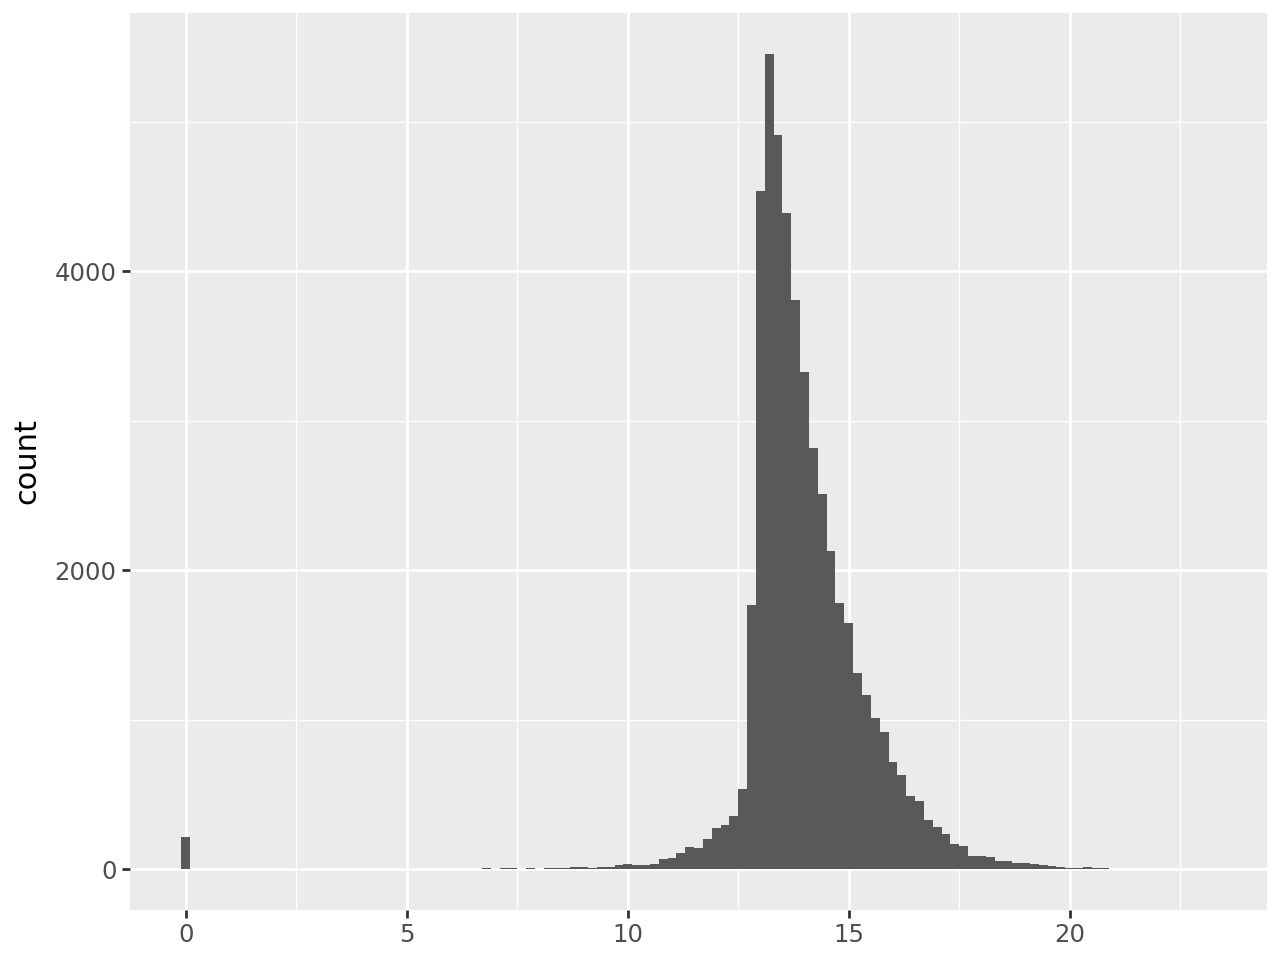

In [26]:

transitions_to = np.sum(bigrams, axis=1)
qplot(x=np.log(1 + transitions_to)) + geom_histogram(binwidth=0.2)

In [31]:
bigrams[[0], :].todense()

array([[0, 0, 0, ..., 0, 0, 0]], dtype=uint32)

In [11]:
occurrences = bigrams.sum(axis=0)
occurrences[occurrences == 0] += 1
occurrences

array([      166,         1, 157123247, ..., 615893065, 213319733,
       695610999], dtype=uint64)

In [12]:
bg = bigrams / occurrences[:, None]

In [ ]:
eigenvalues, eigenvectors = sparselinalg.eigs(bg, k=1000)

In [25]:
eigenvalues

array([ 3.4932413e+09+0.0000000e+00j,  5.2211235e+08+0.0000000e+00j,
       -1.3521040e+08+2.6957133e+08j, -1.3521040e+08-2.6957133e+08j,
       -3.0462666e+08+0.0000000e+00j,  1.4137466e+08+6.4938216e+07j,
        1.4137466e+08-6.4938216e+07j,  1.4795571e+08+0.0000000e+00j,
        1.1634638e+08+1.1600215e+07j,  1.1634638e+08-1.1600215e+07j],
      dtype=complex64)

In [32]:
50_000 ** 2

2500000000

In [30]:

vocab = 4
n = 4
n_states = vocab ** (n-1)
sparse = False

dist = Dirichlet(torch.ones((vocab,)))

base_vocab = partial(in_base_vocab, vocab)
suffixes = list(product(range(vocab), repeat=(n - 1)))
prefixes = sorted(suffixes, key=lambda x: tuple(reversed(x)))

prefix_suffix_mat = torch.block_diag(*dist.sample((n_states,)).split(vocab))
prefix_to_suffix_idx = list(starmap(base_vocab, prefixes))
transition_mat = prefix_suffix_mat[prefix_to_suffix_idx, :]

In [7]:
from scipy.sparse import coo_array
from scipy import linalg
import scipy.sparse.linalg as sparselinalg


if sparse:
    transition_mat = transition_mat.to_sparse()
    rows, cols = np.split(transition_mat.indices().numpy(), 2)
    rows = rows[0]
    cols = cols[0]
    vals = transition_mat.values().numpy()
    transition_np = coo_array((vals, (rows, cols)), shape=(n_states, n_states))
    eigenvalues, _ = linalg.eigs(transition_np, k=1_000)
else:
    eigenvalues = linalg.eigvals(transition_mat.numpy())


data = pl.DataFrame({
    'real': eigenvalues.real,
    'imaginary': eigenvalues.imag,
    'type': ['eig']* len(eigenvalues)
})
    


In [9]:
def sample_eigenvalues(vocab, n, sparse=False):
    n_states = vocab ** (n - 1)

    dist = Dirichlet(torch.ones((vocab,)))
    
    base_vocab = partial(in_base_vocab, vocab)
    suffixes = list(product(range(vocab), repeat=(n-1)))
    prefixes = sorted(suffixes, key=lambda x: tuple(reversed(x)))
    
    prefix_suffix_mat = torch.block_diag(*dist.sample((n_states,)).split(vocab))
    prefix_to_suffix_idx = list(starmap(base_vocab, prefixes))
    transition_mat = prefix_suffix_mat[prefix_to_suffix_idx, :]
    
    if sparse:
        transition_mat = transition_mat.to_sparse()
        rows, cols = np.split(transition_mat.indices().numpy(), 2)
        rows = rows[0]
        cols = cols[0]
        vals = transition_mat.values().numpy()
        transition_np = coo_array((vals, (rows, cols)), shape=(n_states, n_states))
        eigenvalues, _ = linalg.eigs(transition_np, k=1_000)
    else:
        eigenvalues = torch.linalg.eigvals(transition_mat)
    return eigenvalues
            
    

In [10]:
4 ** 7

16384

In [26]:
from tqdm.notebook import tqdm, trange

all_data = []

for _ in trange(5000):
    eigvals = sample_eigenvalues(512, 2)
    #print(torch.count_nonzero(eigvals.imag))
    data = pl.DataFrame({'real': eigvals.real.numpy(), 'imaginary': eigvals.imag.numpy()})
    all_data.append(data)
df = pl.concat(all_data)

  0%|          | 0/5000 [00:00<?, ?it/s]

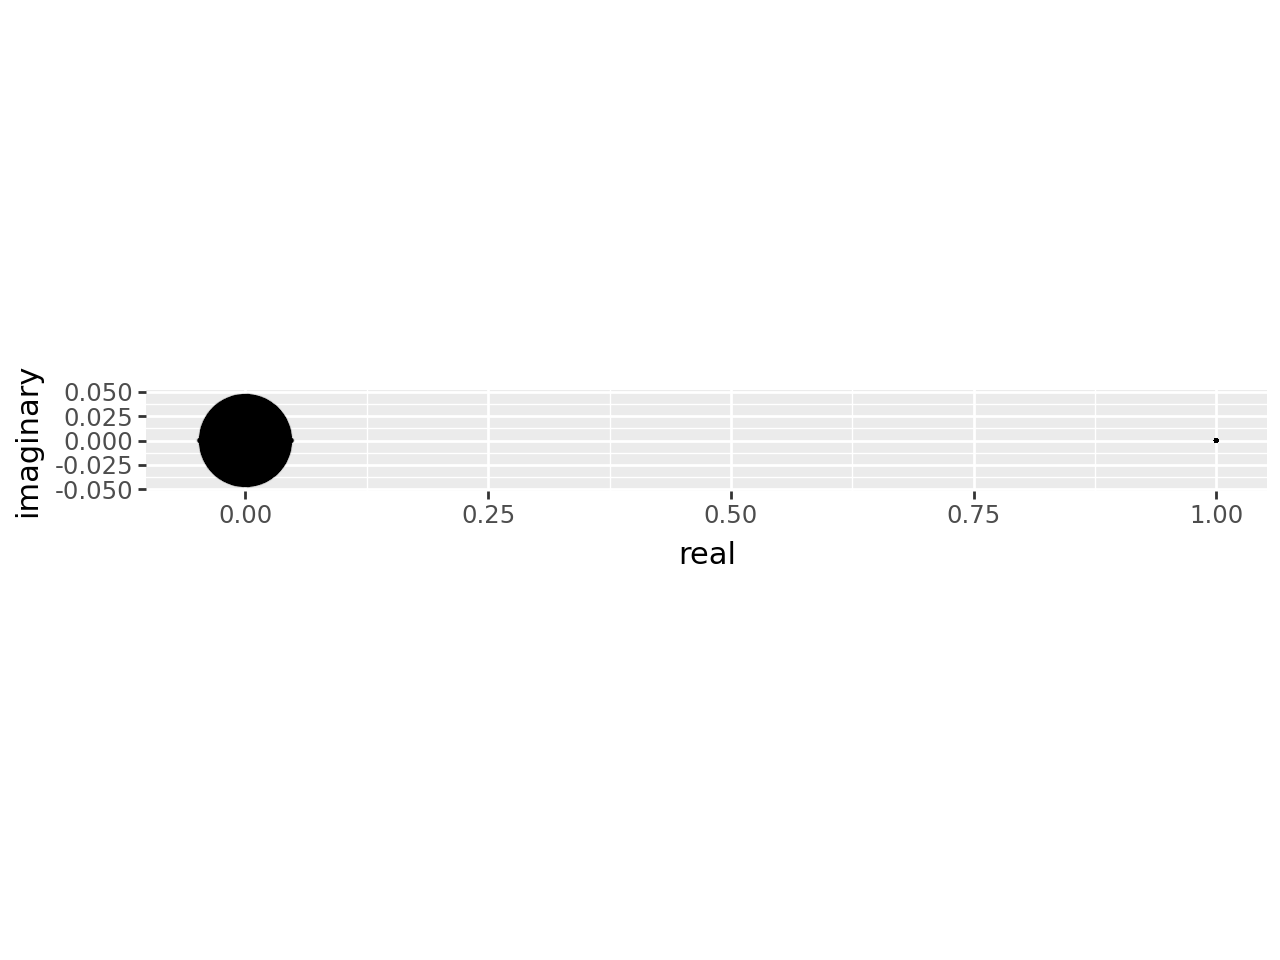

In [28]:
import numpy as np
from plotnine import annotate

theta = np.linspace(0, 2 * np.pi, 5000)

unit_circle = annotate(
    "path",
    x=np.cos(theta),
    y=np.sin(theta),
    color='darkblue'
)

ggplot(df, aes(x='real', y='imaginary')) + geom_point(size=0.001, alpha=0.01) + coord_fixed()

In [228]:
from functools import partial
from collections import deque
import numpy as np

def vocab_to_idx_generator(n_vocab, *indices):
    base_sixteen = reversed([n_vocab**i for i in range(len(indices))])
    return sum([b * idx for (b, idx) in zip(base_sixteen, indices)])


def project_probabilities(probs, unigram_probs):
    """
    Uses the algorithm of alternating between making the rows stochastic (sum to 1.) and columns sum to `unigram_probs`,
    an adaptation of the algorithm described here to generate random bistochastic matrices: https://iopscience.iop.org/article/10.1088/1751-8113/42/36/365209
    Does not end up sampling from the Haar measure on bistochastic matrices, but it converges very quickly.
    """
    curr_sums = probs.sum(axis=0)
    temp_probs = probs * (unigram_probs / curr_sums)[None, :]
    temp_sums = temp_probs.sum(axis=1)[:, None]
    return temp_probs / temp_sums


class NgramSampler:
    
    zipf_epsilon = 1.e-5
    zipf_max_iter = 20

    """
    
    """
    def __init__(self, num_vocab: int, n: int, transition_probs, rng = None):
        self.n = n
        self.zipf_alpha = zipf_alpha
        self.num_vocab = num_vocab
        self.num_states = num_vocab ** (n - 1)
        self.transition_probs = transition_probs
        self.unigram_probs = transition_probs.sum(axis=0) / self.num_states
        self.rng = rng if rng is not None else np.random.default_rng()
        self.vocab_idx_fn = partial(vocab_to_idx_generator, num_vocab)
        assert transition_probs.shape == (self.num_states, self.num_vocab), (self.num_states, self.num_vocab)

        self._state = deque()

    @classmethod
    def sample_zipfian_distribution(cls, num_vocab: int, n: int, zip_alpha: float, rng = None):
        if rng is None:
            rng = np.random.default_rng()
        num_states = num_vocab ** (n - 1)
        transition_probs = rng.dirichlet(np.ones((num_vocab,)), size=(num_states,))
        zipf_probs = (np.arange(num_vocab) + 1) ** (-1 * zipf_alpha)
        zipf_probs /= zipf_probs.sum()
        curr_unigram_probs = transition_probs.sum(axis=0) / num_states
        i = 0
        while not np.allclose(curr_unigram_probs, zipf_probs, atol=cls.zipf_epsilon):
            if i >= cls.zipf_max_iter:
                raise ValueError('Distribution did not converge to Zipfian on unigrams')
            transition_probs = project_probabilities(transition_probs, zipf_probs)
            curr_unigram_probs = transition_probs.sum(axis=0) / num_states
            i += 1
        return cls(num_vocab, n, transition_probs)

    def clear_state(self):
        self._state.clear()

        
    def sample(self, history=None):
        if len(self._state) < (self.n - 1):
            a = self.rng.choice(self.num_vocab, p=self.unigram_probs)
            self._state.append(a)
            return a
        else:
            idx = self.vocab_idx_fn(*tuple(self._state))
            a = self.rng.choice(self.num_vocab, p=self.transition_probs[idx])
            self._state.append(a)
            self._state.popleft()
            return a


In [161]:
zipfian = NgramSampler.sample_zipfian_distribution(32, 2, 1.5)

In [229]:
import torch
from torch.utils.data import IterableDataset, DataLoader


class NgramDataset(IterableDataset):
    def __init__(self, num_vocab, n, zipf_alpha, seq_len, seed, worker_id=None):
        super().__init__()
        self.num_vocab = num_vocab
        self.n = n
        self.zipf_alpha = zipf_alpha
        self.seq_len = seq_len
        self.worker_id = worker_id
        self.seed = seed

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:
            # Single-process data loading
            rng = np.random.default_rng(self.seed)
        else:
            # Multi-process data loading
            worker_id = worker_info.id
            rng = np.random.default_rng(self.seed + worker_id)

        sampler = NgramSampler.sample_zipfian_distribution(self.num_vocab, self.n, self.zipf_alpha, rng)
        while True:
            sequence = [self.num_vocab] + [sampler.sample() for _ in range(self.seq_len)]
            sampler.clear_state()
            yield torch.tensor(sequence, dtype=torch.long)

In [230]:
ngram_data = NgramDataset(32, 5, 1, 128, 0)

In [231]:
data = iter(ngram_data)

next(data)

tensor([32,  0,  0,  2,  2,  0, 18,  0,  0,  2,  0, 12,  9,  1,  0,  1,  0,  6,
        12, 27,  0,  7,  0,  3,  8, 14,  1,  3,  1,  6,  0,  2,  0,  1,  1,  0,
         0,  1,  3,  0,  7,  0,  4,  1,  1,  0,  9,  7,  0,  3,  1,  5,  0, 11,
         0,  1,  0,  4,  0,  3,  0,  0,  0,  0, 12,  1,  0,  0,  0,  2,  7,  1,
         0,  0,  6,  0,  1,  1,  6,  3,  1,  0,  0,  0, 20,  3,  0,  8,  3,  1,
         1,  0,  6,  2,  0,  0,  0,  0,  0,  1,  9,  8, 17,  1,  0,  2,  0, 14,
         4,  8, 30,  7,  0, 13, 22,  0,  2,  1,  1,  8,  0,  0,  3,  0,  3,  0,
         0,  2, 16])

In [264]:
next(data)

tensor([32,  1,  2,  0,  0,  0,  1,  0,  7,  0,  0, 16,  1,  0, 26,  0,  0,  3,
         5, 23,  3, 10,  0,  5,  0,  0,  2,  3,  0,  0,  1,  5,  0,  1,  1,  3,
         0,  0,  6,  2,  0,  0,  0,  1, 11,  3,  0,  0,  3,  1,  0,  6,  1,  0,
         0, 20,  2,  3, 14, 30,  2,  6,  2,  0,  3,  0,  0,  0,  3,  0,  0,  0,
        15,  5,  2,  1, 17,  0,  0,  0,  0,  9, 16,  2,  4,  6,  2,  3,  7,  1,
         7,  3,  1,  0,  7,  0,  3,  1,  0,  0,  0,  7, 25,  0,  0,  0, 18,  3,
         2,  0, 19,  0,  1, 13,  9,  2,  0,  6,  4,  1,  0, 20,  0, 31,  8,  6,
         5, 15,  7])

In [187]:
n = 32
zipf_alpha = 1.4
unigram_probs = (np.arange(n) + 1) ** (-1 * zipf_alpha)
unigram_probs /= unigram_probs.sum()

In [69]:
unigram_probs

array([0.40250761, 0.15252186, 0.08645783, 0.05779498, 0.0422879 ,
       0.03276139, 0.026402  , 0.0219002 , 0.01857097, 0.01602412,
       0.01402246, 0.01241425, 0.01109822, 0.01000449, 0.00908336,
       0.00829862, 0.00762335, 0.00703708, 0.00652408, 0.006072  ,
       0.0056711 , 0.00531352, 0.00499293, 0.00470412, 0.00444281,
       0.00420544, 0.00398901, 0.00379099, 0.00360925, 0.00344195,
       0.00328751, 0.00314459])

In [70]:
probs = rng.dirichlet(np.ones((32,)), size=(32,))


In [75]:
curr_sums = probs.sum(axis=0)

In [136]:
def project_probabilities(probs, unigram_probs):
    curr_sums = probs.sum(axis=0)
    temp_probs = probs * (unigram_probs / curr_sums)[None, :]
    temp_sums = temp_probs.sum(axis=1)[:, None]
    return temp_probs / temp_sums

In [102]:
projected = project_probabilities(probs)
projected

array([[5.81407568e-01, 1.24071567e-02, 6.19643239e-02, ...,
        3.46352701e-03, 5.30976845e-03, 3.60757669e-03],
       [2.32788189e-01, 1.05208514e-01, 1.30564712e-01, ...,
        5.24477355e-04, 1.28459021e-02, 7.57222420e-03],
       [6.16415567e-02, 3.28289578e-01, 1.10981670e-02, ...,
        3.31860282e-03, 3.07830453e-04, 3.62350016e-05],
       ...,
       [1.72416671e-01, 3.52783853e-01, 2.51139470e-02, ...,
        1.34777752e-02, 4.83724436e-04, 6.27315764e-03],
       [3.83264252e-01, 1.99864245e-02, 2.25705397e-01, ...,
        9.94934623e-03, 2.29166866e-03, 3.10788021e-03],
       [2.85721072e-01, 2.16908460e-01, 7.90821628e-02, ...,
        7.17366488e-03, 1.24500831e-02, 9.85381950e-04]])

In [137]:
proj1 = project_probabilities(probs, unigram_probs)
proj2 = project_probabilities(proj1, unigram_probs)
proj3 = project_probabilities(proj2, unigram_probs)
proj4 = project_probabilities(proj3, unigram_probs)
proj5 = project_probabilities(proj4, unigram_probs)

In [138]:
proj1[0, :].sum()

1.0

In [142]:
proj4.sum(axis=0) / 32

array([0.40018907, 0.15348512, 0.08665207, 0.05796336, 0.04233004,
       0.03300237, 0.02650799, 0.02196802, 0.01861298, 0.01605425,
       0.01407421, 0.0124324 , 0.01113962, 0.01004945, 0.00913821,
       0.00832182, 0.00765816, 0.00705942, 0.00654076, 0.00609567,
       0.00568137, 0.0053202 , 0.00500511, 0.00471766, 0.0044503 ,
       0.00421976, 0.0040067 , 0.00380413, 0.00362467, 0.00345403,
       0.00329484, 0.00314626])

In [127]:
unigram_probs

array([0.40250761, 0.15252186, 0.08645783, 0.05779498, 0.0422879 ,
       0.03276139, 0.026402  , 0.0219002 , 0.01857097, 0.01602412,
       0.01402246, 0.01241425, 0.01109822, 0.01000449, 0.00908336,
       0.00829862, 0.00762335, 0.00703708, 0.00652408, 0.006072  ,
       0.0056711 , 0.00531352, 0.00499293, 0.00470412, 0.00444281,
       0.00420544, 0.00398901, 0.00379099, 0.00360925, 0.00344195,
       0.00328751, 0.00314459])

In [77]:
theta = np.linspace(0, 2 * np.pi, 5000)
circle_x = np.cos(theta)
circle_y = np.sin(theta)


circle_plot =  

SyntaxError: invalid syntax (3919872837.py, line 6)

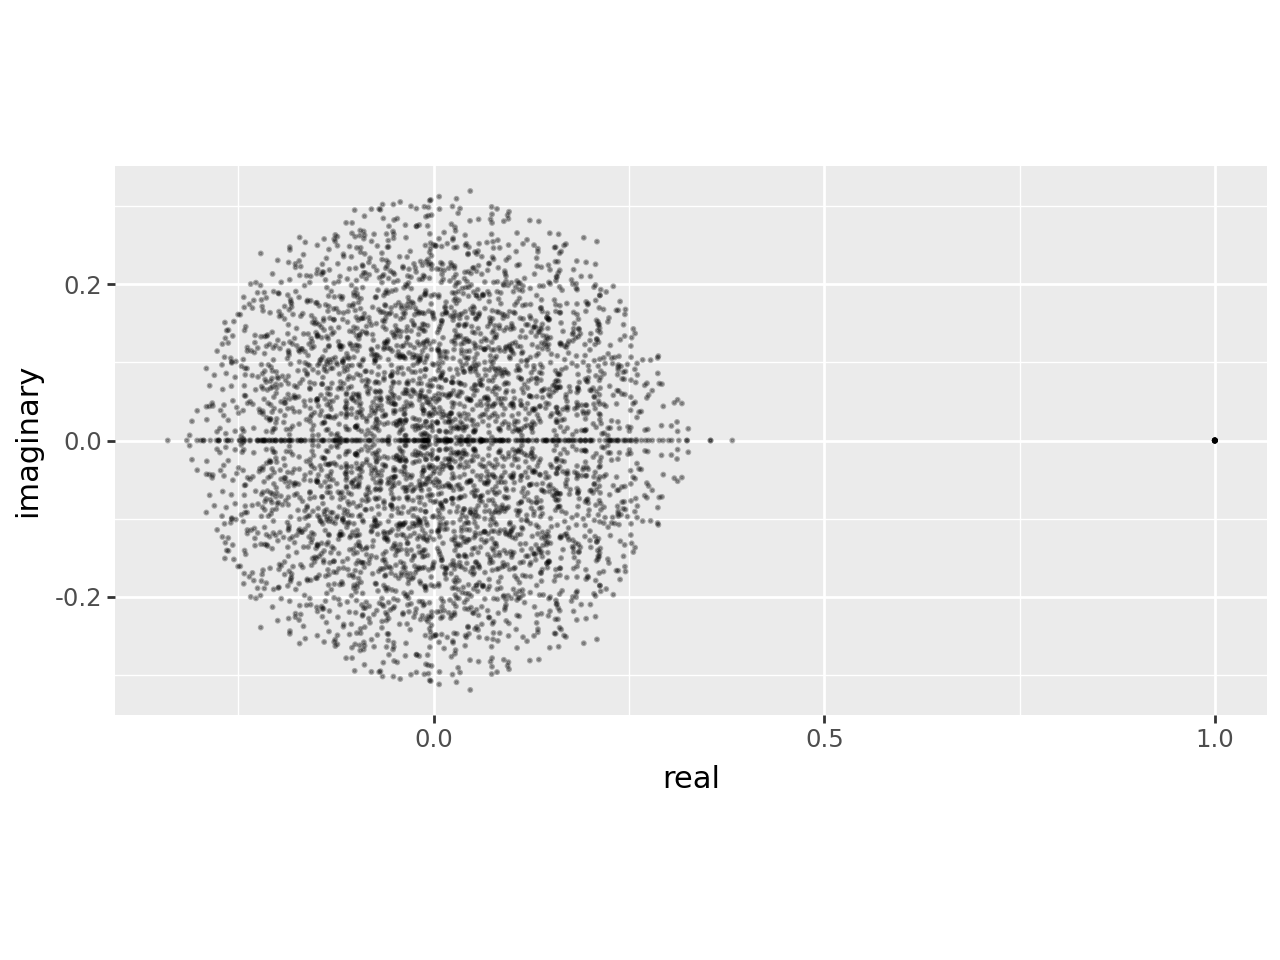